# Tax Revolt Event Dataset: Construction and Spatialization

In [ ]:
import re
import fitz
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

### TEXT EXTRACTION + DF CREATION

Primary source material was extracted from a structured historical compendium of tax-related events.  
This extraction process explicitly accounted for:

- **Embedded images and captions**, ensuring captions were not misclassified as event descriptions
- **Irregular formatting artifacts**, including line breaks, footnote markers, and truncated references
- **"See References" fields**, which were preserved as a distinct column and pruned post-hoc for future NLP and citation-network analysis

All extracted text was normalized into a tabular format prior to downstream processing, allowing later enrichment without re-parsing source documents.

In [2]:
## LOAD IN BOOK
pdf_path = "/Users/aidanlee/Desktop/tax-revolt-project/A World History of Tax Rebellions.pdf"  ## CHANGE PATH ACCORDINGLY
doc = fitz.open(pdf_path)

## CROP PAGES (EXLCUDE HEADERS & PAGE NUMBERS)
rect = fitz.Rect(0, 50, 850, 1100)

## SECTION TITLES TO IGNORE WHEN PARSING
exact_titles = {
    "ANCIENT WORLD",
    "EARLY MIDDLE AGES, AD 365–1199",
    "LATE MIDDLE AGES, 1200–1500",
    "RENAISSANCE TO ENLIGHTENMENT, 1500–1700",
    "EIGHTEENTH CENTURY",
    "NINETEENTH CENTURY",
    "TWENTIETH AND TWENTY-FIRST CENTURIES"}

In [3]:
## IMAGE CAPTION PRUNING

CAPTION_SKIP_PAGES = {24, 239}  ## DO NOT PRUNE CAPTIONS ON THESE PAGES (24: CAPTION SLIGHTLY MISALIGNED LEFT, 239: NO CAPTION)

def clean_pruned_caption_artifacts(text: str) -> str:

    if not text:
        return text

    # join: "... was" + newline(s) + opening quote -> "... was “"
    text = re.sub(r"(\bwas)\s*\n+\s*(“)", r"\1 \2", text)

    # whitespace normalization
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"[ \t]*\n[ \t]*", "\n", text)

    return text.strip()

##### Image and Caption Handling

The source material includes embedded images and image captions interspersed with textual descriptions. During extraction, captions were explicitly identified and excluded from event descriptions to prevent misclassification as narrative content. This ensures that visual metadata does not contaminate downstream text analysis, classification, or language-model inference, while preserving the integrity of event-level descriptions.

In [4]:
## IMAGE + CAPTION DETECTION (FITZ LAYOUT)

def _block_text_preserve_lines(block: Dict[str, Any]) -> str:
    out_lines = []
    for line in block.get("lines", []):
        line_txt = "".join(span.get("text", "") for span in line.get("spans", []))
        out_lines.append(line_txt)
    return "\n".join([ln.rstrip() for ln in out_lines]).strip()

def _h_overlap_ratio(a: Tuple[float, float, float, float], b: Tuple[float, float, float, float]) -> float:
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter = max(0.0, min(ax1, bx1) - max(ax0, bx0))
    aw = max(1e-6, ax1 - ax0)
    bw = max(1e-6, bx1 - bx0)
    return inter / min(aw, bw)

def _looks_like_caption_text(s: str, max_words: int = 45) -> bool:
    t = (s or "").strip()
    if not t:
        return False
    if t.upper() == "BIBLIOGRAPHY":
        return False
    # avoid mistaking event headers as captions
    if re.match(r"^(?:c\.?\s*)?(?:AD\s*)?\d{1,4}\b", t):
        return False
    if len(t.split()) > max_words:
        return False
    return True

def extract_page_images_and_captions(
    page: fitz.Page,
    *,
    max_gap_pts: float = 80.0,
    max_caption_height_pts: float = 220.0,
    min_h_overlap: float = 0.12,
) -> List[Dict[str, Any]]:
    """
    Find images (type=1) and capture the EXACT text block directly below each image.
    Uses full page layout (no clip).
    Skips caption detection on CAPTION_SKIP_PAGES (but still lists images for auditing).
    """
    page_num = page.number + 1

    d = page.get_text("dict")  # NO CLIP
    blocks = d.get("blocks", [])

    img_blocks  = [b for b in blocks if b.get("type") == 1]
    text_blocks = [b for b in blocks if b.get("type") == 0]

    rows = []

    # denylist: report images but do not detect captions
    if page_num in CAPTION_SKIP_PAGES:
        for img_i, img in enumerate(img_blocks, start=1):
            rows.append({
                "page": page_num,
                "image_index_on_page": img_i,
                "image_bbox": img["bbox"],
                "caption_bbox": None,
                "caption_gap_pts": None,
                "caption_raw": "",
                "caption_singleline": "",
            })
        return rows

    for img_i, img in enumerate(img_blocks, start=1):
        ix0, iy0, ix1, iy1 = img["bbox"]

        candidates = []
        for tb in text_blocks:
            tx0, ty0, tx1, ty1 = tb["bbox"]
            gap = ty0 - iy1
            if gap < 0 or gap > max_gap_pts:
                continue

            overlap = _h_overlap_ratio((ix0, iy0, ix1, iy1), (tx0, ty0, tx1, ty1))
            if overlap < min_h_overlap:
                continue

            if ty1 > (iy1 + max_gap_pts + max_caption_height_pts):
                continue

            txt = _block_text_preserve_lines(tb)
            if not _looks_like_caption_text(txt):
                continue

            img_center_x = (ix0 + ix1) / 2.0
            tb_center_x  = (tx0 + tx1) / 2.0
            centered_dist = abs(tb_center_x - img_center_x)

            candidates.append((gap, centered_dist, txt, tb))

        if candidates:
            gap, centered_dist, caption_raw, cap_block = sorted(candidates, key=lambda x: (x[0], x[1]))[0]
            caption_bbox = cap_block["bbox"]
        else:
            caption_raw = ""
            caption_bbox = None
            gap = None

        rows.append({
            "page": page_num,
            "image_index_on_page": img_i,
            "image_bbox": img["bbox"],
            "caption_bbox": caption_bbox,
            "caption_gap_pts": gap,
            "caption_raw": caption_raw,
            "caption_singleline": re.sub(r"\s+", " ", caption_raw).strip()})

    return rows

def extract_all_images_and_captions(doc: fitz.Document) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for pno in range(len(doc)):
        rows.extend(extract_page_images_and_captions(doc[pno]))
    return pd.DataFrame(rows)

In [5]:
## CAPTION PRUNE MAP + LINE REMOVAL

def build_caption_removal_map(df_images: pd.DataFrame) -> Dict[int, List[str]]:

    cap_map: Dict[int, List[str]] = {}
    if df_images is None or df_images.empty:
        return cap_map

    for _, r in df_images.iterrows():
        page_num = int(r["page"])
        raw = (r.get("caption_raw") or "").strip()
        if not raw:
            continue
        lines = [ln.strip() for ln in raw.split("\n") if ln.strip()]
        if not lines:
            continue
        cap_map.setdefault(page_num, []).extend(lines)

    # de-dupe per page
    for p in list(cap_map.keys()):
        seen = set()
        uniq = []
        for ln in cap_map[p]:
            if ln not in seen:
                seen.add(ln)
                uniq.append(ln)
        cap_map[p] = uniq

    return cap_map

def remove_caption_lines_from_text(page_text: str, lines_to_remove: List[str]) -> Tuple[str, int]:
    """
    Remove caption lines only when they appear as standalone lines.
    Returns (new_text, removed_count).
    """
    if not lines_to_remove:
        return page_text, 0

    kill = set(lines_to_remove)
    out = []
    removed = 0
    for ln in page_text.replace("\r", "").split("\n"):
        if ln.strip() in kill:
            removed += 1
            continue
        out.append(ln)
    return "\n".join(out), removed

In [6]:
## PAGE TEXT EXTRACTION (CROP + CAPTION PRUNE + TITLE STRIP)

df_images = extract_all_images_and_captions(doc)
print("Image blocks found:", 0 if df_images.empty else len(df_images))

caption_remove_map = build_caption_removal_map(df_images)

all_text_cleaned: List[str] = []

for page in doc:
    page_num = page.number + 1

    # crop-based text extraction
    page_text = page.get_text("text", clip=rect).replace("\r", "")

    # prune caption lines
    page_text, removed_n = remove_caption_lines_from_text(page_text, caption_remove_map.get(page_num, []))

    # post-prune cleanup (only when something was removed, and not on skip pages)
    if removed_n > 0 and page_num not in CAPTION_SKIP_PAGES:
        page_text = clean_pruned_caption_artifacts(page_text)

    # strip section titles
    lines = page_text.split("\n")
    filtered_lines = [ln for ln in lines if ln.strip() not in exact_titles]
    cleaned = "\n".join(filtered_lines).replace("\r", "")

    # collapse 3+ blank lines -> 2
    while "\n\n\n" in cleaned:
        cleaned = cleaned.replace("\n\n\n", "\n\n")

    all_text_cleaned.append(cleaned)

full_text = "\n".join(all_text_cleaned)

Image blocks found: 44


In [7]:
## TEXT UNWRAP + DEHYPHENATION

DEHYPH_EOL_RE = re.compile(r"(?<=\w)-\n(?=\w)")
DEHYPH_SPACE_RE = re.compile(r"(?<=[A-Za-z])-\s+(?=[A-Za-z])")

def dehyphenate_eol(text: str) -> str:
    return DEHYPH_EOL_RE.sub("", text)

def dehyphenate_after_unwrap(text: str) -> str:
    return DEHYPH_SPACE_RE.sub("", text)

def unwrap_preserving_paragraphs(text: str) -> str:
    text = text.replace("\r", "")
    text = dehyphenate_eol(text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    text = dehyphenate_after_unwrap(text)
    text = re.sub(r"[ \t]{2,}", " ", text).strip()
    return text

In [8]:
## BIBLIOGRAPHY SPLIT

BIB_MARKER_RE = re.compile(r"\nBIBLIOGRAPHY\s*\n")
NEW_CIT_RE = re.compile(r"^\s*[A-Z][^,]{1,80},\s+\S")
DASH_CONT_RE = re.compile(r"^\s*[—–-]\s*\S")

def split_bibliography_lines(biblio_block: str) -> List[str]:
    if not biblio_block:
        return []

    biblio_block = biblio_block.replace("\r", "")
    biblio_block = dehyphenate_eol(biblio_block)
    biblio_block = dehyphenate_after_unwrap(biblio_block)

    raw_lines = [ln.rstrip() for ln in biblio_block.split("\n")]

    citations: List[str] = []
    current = ""

    for ln in raw_lines:
        if not ln.strip():
            if current.strip():
                citations.append(re.sub(r"\s{2,}", " ", current).strip())
                current = ""
            continue

        if NEW_CIT_RE.match(ln) or DASH_CONT_RE.match(ln):
            if current.strip():
                citations.append(re.sub(r"\s{2,}", " ", current).strip())
            current = ln.strip()
        else:
            current = (current + " " + ln.strip()).strip() if current else ln.strip()

    if current.strip():
        citations.append(re.sub(r"\s{2,}", " ", current).strip())

    return citations

In [9]:
## ENTRY HEADER MATCH

TIME_RE = r"""(?:
    (?:c\.?\s*)?(?:AD\s*)?\d{1,4}(?:\s*or\s*\d{1,4})?(?:[–\-]\d{1,4})?\s*(?:BC|AD)?
  | \d{3,4}[sS]
  | (?:(?:Early|Mid|Late)\s+)\d{3,4}[sS])"""

TIME_RE = re.compile(TIME_RE, re.VERBOSE)
SEP_RE = r"(?:\s+|[—–-]\s*)"

ENTRY_HEADER = re.compile(
    rf"^(?P<time>{TIME_RE.pattern}){SEP_RE}(?P<name>.+?)\s*\((?P<location>[^)]+)\),",
    flags=re.MULTILINE | re.VERBOSE)

In [10]:
## CHANGE LOG HELPERS

def record_change(changes: List[Dict[str, Any]], field: str, before: str, after: str, context: Dict[str, Any]) -> None:
    if before != after:
        changes.append({"Field": field, "Before": before, "After": after, **context})

def shorten(s: str, n: int = 250) -> str:
    s = s or ""
    return s if len(s) <= n else s[:n] + "…"

In [11]:
## PARSE ENTRIES -> DF

entries: List[Dict[str, Any]] = []
change_log: List[Dict[str, Any]] = []

matches = list(ENTRY_HEADER.finditer(full_text))

for i, m in enumerate(matches):
    start = m.end()
    end = matches[i + 1].start() if i + 1 < len(matches) else len(full_text)
    body = full_text[start:end].strip()

    desc_text = body
    biblio_block = ""

    bib_match = BIB_MARKER_RE.search(body)
    if bib_match:
        desc_text = body[:bib_match.start()]
        biblio_block = body[bib_match.end():]

    ctx = {
        "Time Period": m.group("time").strip(),
        "Rebellion": m.group("name").strip(),
        "Location": m.group("location").strip(),
        "Index": i}

    desc_before = desc_text.replace("\r", "")
    desc_after = unwrap_preserving_paragraphs(desc_text)
    record_change(change_log, "Description", shorten(desc_before), shorten(desc_after), ctx)

    bib_before = biblio_block.replace("\r", "")
    sources_list = split_bibliography_lines(biblio_block)
    bibliography_after = "\n".join(sources_list)
    record_change(change_log, "Bibliography", shorten(bib_before), shorten(bibliography_after), ctx)

    entries.append({
        "Rebellion": ctx["Rebellion"],
        "Time Period": ctx["Time Period"],
        "Location": ctx["Location"],
        "Description": desc_after,
        "Bibliography": bibliography_after,
        "Bibliography Count": len(sources_list)})

df = pd.DataFrame(entries, columns=[
    "Rebellion", "Time Period", "Location", "Description", "Bibliography", "Bibliography Count"])

print(f"Extracted {len(df)} entries.")

df_changes = pd.DataFrame(change_log, columns=[
    "Index", "Time Period", "Rebellion", "Location", "Field", "Before", "After"])

print(f"Logged {len(df_changes)} field modifications.")

Extracted 391 entries.
Logged 443 field modifications.


In [12]:
## VALIDATE IMAGE CAPTION PRUNING

pruned = df_images[df_images["caption_raw"].str.strip() != ""]

print(f"Total captions removed: {len(pruned)}")

for _, r in pruned.iterrows():
    print("\n" + "-" * 70)
    print(f"Page {r['page']} | Image #{r['image_index_on_page']}")
    print("RAW CAPTION:")
    print(r["caption_raw"])

Total captions removed: 39

----------------------------------------------------------------------
Page 18 | Image #1
RAW CAPTION:
Frisians in Battle.

----------------------------------------------------------------------
Page 34 | Image #1
RAW CAPTION:
“Battle between Emperor Constantine and Maxentius” by Peter Paul Rubens.

----------------------------------------------------------------------
Page 55 | Image #1
RAW CAPTION:
Empress Nu.

----------------------------------------------------------------------
Page 71 | Image #1
RAW CAPTION:
Lady Godiva.

----------------------------------------------------------------------
Page 78 | Image #1
RAW CAPTION:
Magna Carta.

----------------------------------------------------------------------
Page 90 | Image #1
RAW CAPTION:
“Seizure of Boniface VIII by Emissaries of Philip IV” by G.Fattorusso.

----------------------------------------------------------------------
Page 106 | Image #1
RAW CAPTION:
“Walter of Brienne resigns the signory of 

In [13]:
## PAGE 24 MANUAL IMAGE CAPTION PRUNE

def clean_judaea_boadicea_and_quote(text: str) -> str:
    if not text:
        return text

    text = re.sub(r"(?m)^\s*Boadicea\.\s*$\n?", "", text)
    text = re.sub(r"(?<=\s)Boadicea\.(?=\s|$|[”\"'])", "", text)

    text = re.sub(r"(Josephus’s account was)\s*\n+\s*(“)", r"\1 \2", text)

    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"[ \t]*\n[ \t]*", "\n", text)

    return text.strip()

df.loc[df["Rebellion"].eq("Judaea Revolt"), "Description"] = (df.loc[df["Rebellion"].eq("Judaea Revolt"), "Description"].map(clean_judaea_boadicea_and_quote))
row = df.loc[df["Rebellion"].eq("Judaea Revolt")].iloc[0]
print(row["Time Period"], "|", row["Rebellion"], "(", row["Location"], ")")
print()
print(row["Description"])

AD 66–70 | Judaea Revolt ( Judaea, Roman Empire )

rebellion by the Jews in the Roman province of Judaea sparked in part by the Roman governors’ imposition of burdensome taxes. The heavy taxes apparently resulted from Emperor Nero’s fiscal excesses, including the costs of rebuilding Rome (perhaps half destroyed by the great fire in July 64), and most especially the costs of constructing Nero’s new palace, the Domus Aurea (golden house), with its resplendent art, adornments, and grounds. (Suetonius described the “golden house” as so large “that it contained three galleries of a mile apiece in length. Also, a standing pool like unto a sea, and the same enclosed round about with buildings in the form of cities.”) Whether the result of Nero’s excesses, the Roman governors (procurators) of Judaea nevertheless, exacerbated the tax burden. Although Festus had performed well as procurator in reducing the scourge of the Judaean bandits, his

successors proved feckless at best. Albinus, who imme

In [14]:
## BIBLIOGRAPHY SANITY CHECK

bad_end_period = df[
    (df["Bibliography"].str.strip() != "") &
    (~df["Bibliography"].str.strip().str.endswith(".", na=False))]

print("Rows where bibliography does not end with a period:", len(bad_end_period))
print(bad_end_period[["Time Period", "Rebellion", "Location", "Bibliography Count"]].head(20))

Rows where bibliography does not end with a period: 0
Empty DataFrame
Columns: [Time Period, Rebellion, Location, Bibliography Count]
Index: []


In [15]:
## DE-HYPHEN SANITY CHECK

hyphen_artifacts = df[df["Description"].str.contains(r"\b\w+-\s+\w+\b", regex=True, na=False)]

print("Rows with probable hyphenation artifacts:", len(hyphen_artifacts))
print(hyphen_artifacts[["Time Period", "Rebellion", "Location"]].head(20))

Rows with probable hyphenation artifacts: 1
    Time Period Rebellion Location
349        1900  Acre War  Bolivia


In [16]:
## MANUAL CORRECTIONS AFTER REVIEW

mask = (df["Rebellion"] == "Acre War") & (df["Description"].str.contains("mid- 1890s"))
df.loc[mask, "Description"] = df.loc[mask, "Description"].str.replace("mid- 1890s", "mid-1890s", regex=False)

mask = df["Time Period"] == "Early 900S"
df.loc[mask, "Time Period"] = "Early 900s"

mask = df["Rebellion"] == "PancarteResistance"
df.loc[mask, "Rebellion"] = "Pancarte Resistance"

mask = df["Rebellion"] == "VintemRiot"
df.loc[mask, "Rebellion"] = "Vintem Riot"

##### Handling of “See References” Fields

“See References” entries were extracted as a dedicated column rather than merged into descriptive text. Post-hoc pruning was applied to remove formatting artifacts, duplicated citations, and non-referential markers introduced during extraction. These references were retained in cleaned form to support future citation analysis and NLP-based source linkage, without influencing event classification or spatial–temporal inference.

In [17]:
## EXTRACT "(See..)" FROM DESCRIPTION AND PLACE IN NEW COLUMN

def strip_see_references(text: str):

    if not text:
        return text, None

    see_refs = re.findall(
        r"\(\s*See(?:\s+also)?([^)]*)\)",
        text,
        flags=re.IGNORECASE)

    # remove them from text
    cleaned = re.sub(
        r"\(\s*See(?:\s+also)?[^)]*\)",
        "",
        text,
        flags=re.IGNORECASE)

    # normalize whitespace
    cleaned = re.sub(r"\s{2,}", " ", cleaned)
    cleaned = re.sub(r"[ \t]*\n[ \t]*", "\n", cleaned)

    return cleaned.strip(), [r.strip() for r in see_refs] if see_refs else None

df[["Description", "See References"]] = (df["Description"].apply(strip_see_references).apply(pd.Series))

In [18]:
print(len(df))
df.head()

391


,Rebellion,Time Period,Location,Description,Bibliography,Bibliography Count,See References
0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,tax reduction and related reforms effected by ...,"Samuel Noah Kramer, From the Tablets of Sumer....",1,None
1,Kiddinutu,2000 BC,Assyria,"legal “status of being under the kiddinu,” ass...","A.Leo Oppenheim, Ancient Mesopotamia: Portrait...",2,None
2,Delian League Revolt,431 BC,Greece,uprising of cities allied with Athens in the D...,"Andreas Michael Andreades, A History of Greek ...",2,None
3,Rebellion Against Tachos,c. 361 or 360 BC,Egypt,uprising instigated by repressive taxation imp...,"B.G.Trigger et al., Ancient Egypt: A Social Hi...",1,None
4,Khabbash Revolt,c. 338 BC,Egypt,"apparent uprising, led by the pharaoh Khabbash...","B.G.Trigger et al., Ancient Egypt: A Social Hi...",1,None


In [19]:
df[~df['See References'].isna()].head()

,Rebellion,Time Period,Location,Description,Bibliography,Bibliography Count,See References
28,Iceni Revolt,AD 60,Britain,uprising against Roman oppression and taxation...,"Dio Cassius, Roman History, Books LXI–TXX, tra...",6,[BOADICEA.]
30,Gaul Revolt,AD 68,"Gaul province, Roman Empire",rebellion largely generated by excessive taxat...,"Charles Freeman, Egypt, Greece, and Rome. Oxfo...",3,[AD 60—ICENI REVOLT; AD 66–70—JUDAEA REVOLT.]
37,"Roman Revolution, or Maxentius’s Revolt",AD 306,"Rome, Roman Empire",brutal rebellion led by Marcus Aurelius Valeri...,"Arnold H.M.Jones, The Later Roman Empire, 284–...",4,[Zosimus’s account of the battle.]
39,Rebellion of Firmus,372,"North Africa, Roman Empire",major revolt against “inordinate tax demands” ...,"Susan Raven, Rome in Africa, new ed. London an...",1,[AD 17–24—TACFARINAS’S REVOLT.]
41,Pannonian Tax Resistance,375,"Pannonia, Roman Empire","opposition to taxes imposed by Probus, the pra...","Andras Mocsy, Pannonia and Upper Moesia, trans...",1,[374–375—MAURETANIAN REBELLION.]


In [20]:
df_changes.tail()

,Index,Time Period,Rebellion,Location,Field,Before,After
438,387,2001,Separatist Movement,Canada,Bibliography,"Tamsin Carlisle and Joel Baglole, “In Western ...","Tamsin Carlisle and Joel Baglole, “In Western ..."
439,388,2001,Tennessee Income Tax Protest,United States,Description,protest in July at the Capitol in Nashville ag...,protest in July at the Capitol in Nashville ag...
440,388,2001,Tennessee Income Tax Protest,United States,Bibliography,"“Asides, Tax Revolts,” The Wall Street Journal...","“Asides, Tax Revolts,” The Wall Street Journal..."
441,389,2002,Restauranteurs’ Strike,France,Description,a strike in Paris on February 18 by hundreds o...,a strike in Paris on February 18 by hundreds o...
442,390,2002,Tax Opposition,Ascension Island,Description,protests by the 850 residents of Ascension Isl...,protests by the 850 residents of Ascension Isl...


In [21]:
final_df = df.drop(columns=["Bibliography Count"])
## final_df.to_json('/Users/aidanlee/Desktop/tax-revolt-project/tax_revolts.json')  ## CHANGE TO PATH OF DESIRED OUTPUT

In [22]:
final_df.head()

,Rebellion,Time Period,Location,Description,Bibliography,See References
0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,tax reduction and related reforms effected by ...,"Samuel Noah Kramer, From the Tablets of Sumer....",None
1,Kiddinutu,2000 BC,Assyria,"legal “status of being under the kiddinu,” ass...","A.Leo Oppenheim, Ancient Mesopotamia: Portrait...",None
2,Delian League Revolt,431 BC,Greece,uprising of cities allied with Athens in the D...,"Andreas Michael Andreades, A History of Greek ...",None
3,Rebellion Against Tachos,c. 361 or 360 BC,Egypt,uprising instigated by repressive taxation imp...,"B.G.Trigger et al., Ancient Egypt: A Social Hi...",None
4,Khabbash Revolt,c. 338 BC,Egypt,"apparent uprising, led by the pharaoh Khabbash...","B.G.Trigger et al., Ancient Egypt: A Social Hi...",None


### LLM CLASSIFICATION

The goal of this section is to systematically classify tax-related contentious events using a large language model as a structured coding assistant. Rather than generating new historical claims, the model is used to interpret existing descriptions and assign standardized labels capturing mechanisms, actors, tactics, targets, and outcomes.

In [2]:
import os
import time
from openai import OpenAI
from dotenv import load_dotenv

## LOAD IN API KEY
load_dotenv("tax_revolt_project.env")
OPENAI_API_KEY =  os.getenv("OPENAI_API_KEY") 

client = OpenAI()  # uses OPENAI_API_KEY from env

In [24]:
MODEL = "gpt-5.2"
BATCH_SIZE = 20
OUT_PATH = "llm_event_classifications.jsonl"
SLEEP_BETWEEN_BATCHES = 0.5

##### First LLM API Call: Structured Event Classification (Inputs → Outputs)

This first API call sends the model a *single event description* at a time (pulled from the dataframe’s `Description` field). The request includes:
- a **system prompt** that fixes the model’s role (“careful research assistant for a PhD thesis”) and requires **STRICT JSON only** (no prose),
- a **user prompt** that embeds the event text and asks for a standardized set of coding fields.

**Input to the model (per row):**
- The historical **Description** string (optionally trimmed for length consistency)
- Instructions to return a JSON object with the following keys:
  - `mechanism` (list of causal/fiscal mechanisms driving contention)
  - `actors` (who is involved)
  - `tactics` (how contention is expressed)
  - `targets` (what institutions/actors/policies are contested)
  - `outcome` (what happened as a result)
  - `confidence` (0–1)
  - `rationale` (1–2 sentences summarizing why the coding fits)
  - `keywords` (5–10 salient terms for retrieval / auditing)

**Output produced (per row):**
- One JSON object containing the above fields, which is written to a `.jsonl` cache file alongside the row identifier so results can be merged back into the dataframe later.
- If parsing fails or the API returns an error, the pipeline records an error object for that row (instead of stopping the run), so failures can be reviewed and rerun selectively.

##### Why include confidence scores?

The `confidence` field is an *epistemic uncertainty signal*—it captures how strongly the model believes the classification is supported by the **available description**, not whether the event is “important” or “real.”  
This is useful because historical entries vary in specificity: some descriptions clearly identify the tax instrument, actors, and outcome, while others are vague, truncated, or mix multiple episodes.

Practically, confidence scores allow you to:
- **triage** which events need manual review first (low-confidence items),
- **weight** downstream summaries/visualizations (so ambiguous codings contribute less),
- **audit reliability** by comparing confidence against your expert recoding decisions and identifying systematic failure modes (e.g., sparse descriptions, overlapping categories, anachronistic labels).

##### tl;dr this call generates a consistent, machine-readable *first-pass coding layer* across all events, while preserving an uncertainty measure that supports later validation and refinement.

In [25]:
SYSTEM = """You are a careful research assistant for a PhD thesis.
Your task is to classify tax-related rebellions based on short historical descriptions.
Use short human-readable phrases, not machine tokens. Avoid snake_case.
Return valid JSON only. Do not include any explanatory text outside JSON."""

def make_user_prompt(desc: str) -> str:
    return f"""
Classify the historical event described below.

Return JSON with the following keys:
- classification: str
- mechanism: list[str]
- actors: list[str]
- tactics: list[str]
- targets: list[str]
- outcome: list[str]
- confidence: number (0 to 1)
- rationale: string (1–2 sentences)
- keywords: list[str] (5–10)

Description:
\"\"\"{desc.strip()}\"\"\"
""".strip()

In [26]:
df = final_df.copy()

def already_done_indices(path: str) -> set[int]:
    if not os.path.exists(path):
        return set()
    done = set()
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                done.add(obj["row_index"])
            except Exception:
                continue
    return done

done = already_done_indices(OUT_PATH)

rows = [
    (i, desc)
    for i, desc in enumerate(df["Description"].astype(str))
    if i not in done]

print("Remaining events to classify:", len(rows))

with open(OUT_PATH, "a", encoding="utf-8") as f:
    for start in range(0, len(rows), BATCH_SIZE):
        batch = rows[start:start + BATCH_SIZE]

        for row_index, desc in batch:
            try:
                resp = client.chat.completions.create(
                    model=MODEL,
                    temperature=0.2,
                    messages=[
                        {"role": "system", "content": SYSTEM},
                        {"role": "user", "content": make_user_prompt(desc)}
                    ],
                )

                content = resp.choices[0].message.content
                data = json.loads(content)  

                record = {
                    "row_index": row_index,
                    **data
                }

                f.write(json.dumps(record, ensure_ascii=False) + "\n")

            except Exception as e:
                f.write(json.dumps({
                    "row_index": row_index,
                    "error": str(e)
                }) + "\n")

        f.flush()
        time.sleep(SLEEP_BETWEEN_BATCHES)

Remaining events to classify: 391


In [116]:
PATH = "llm_event_classifications.jsonl" 

records = []
with open(PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        records.append(obj)

df_lab = pd.DataFrame(records)

df_lab.head(5)

,row_index,classification,mechanism,actors,tactics,targets,outcome,confidence,rationale,keywords
0,0,Popular uprising against oppressive taxation l...,"[Tax revolt, Anti-bureaucratic backlash, Regim...","[Lagash citizens (farmers, herders, fishermen,...","[Collective uprising, Expulsion/overthrow of r...","[Ur-Nanshe dynasty, Tax collectors and inspect...","[Dynasty overthrown and replaced by Urukagina,...",0.74,The description explicitly links oppressive ta...,"[Lagash, Urukagina, Ur-Nanshe dynasty, tax col..."
1,1,Urban tax resistance leading to negotiated fis...,"[Collective refusal or resistance to taxes, tr...",[Native-born citizens of privileged cities (As...,"[Withholding taxes and tribute, Refusal of cor...","[Monarchical fiscal claims (toll, tribute, cus...",[Formalized exemptions from taxes and corvée f...,0.74,The description links city resistance to payin...,"[kiddinu, kiddinutu, free city, tax exemption,..."
2,2,Anti-tribute revolt within an imperial allianc...,"[Resistance to burdensome tribute assessments,...",[Delian League allied city-states (Ionian and ...,[Collective uprising and secession attempts by...,"[Athenian tribute system and assessments, Athe...",[Outbreak and intensification of the Peloponne...,0.78,The description centers on allied city-states ...,"[Delian League, Athens, tribute, allied revolt..."
3,3,Anti-tax uprising leading to deposition of a r...,"[War finance taxation backlash, Fiscal repress...","[Egyptian taxpayers and populace, Egyptian pol...","[Uprising and mass unrest, Political revolt cu...","[Pharaoh Tachos, Royal fiscal administration a...","[Deposition of Tachos as pharaoh, Termination ...",0.78,"The description explicitly links heavy, repres...","[Tachos, Egypt, repressive taxation, war finan..."
4,4,Anti-imperial tax revolt against Persian rule ...,[Resistance to heavy taxation and fiscal extra...,"[Pharaoh Khabbash and Egyptian rebels, Persian...","[Armed rebellion, Political mobilization aroun...","[Persian tax collectors and administrators, Pe...",[Revolt occurred or was attempted but is poorl...,0.62,The description links the uprising to Persian ...,"[Khabbash, Artaxerxes III, Persian rule in Egy..."


##### Diversity Sampling for Taxonomy Design

To avoid building a taxonomy from a biased slice of the corpus (the first 200 events, excluding modern events), I constructed a **diversity sample** directly from the embedding matrix `X`. Here, each row of `X` is a vector representation of an event (derived from the event text), and **cosine distance** is used as the similarity metric so that “distance” corresponds to semantic dissimilarity in the embedding space.

The sampling procedure uses a greedy *max–min (farthest-point)* algorithm: starting from a random event, it iteratively selects the event that is farthest (in cosine distance) from all previously selected events. This ensures that each new addition maximally expands semantic coverage, rather than reinforcing already-dense regions of the embedding space. The result is a set of events that spans rare, extreme, and historically distinct cases alongside more common ones.

To validate coverage, the full corpus and the diversity sample are visualized in two dimensions using both **PCA** (to assess global variance and large-scale structure) and **UMAP** (to assess local neighborhoods and cluster-level diversity). Together, these views confirm that the selected events are distributed across the full semantic space, providing a robust and representative foundation for downstream taxonomy construction.

In [117]:
X = np.load("embeddings_desc_meta.npy")

In [118]:
from sklearn.metrics import pairwise_distances

def diversity_sample(X, k, seed=7):
    rng = np.random.default_rng(seed)

    n = X.shape[0]
    selected = []

    first = rng.integers(n)
    selected.append(first)

    # distances to nearest selected point
    min_dist = pairwise_distances(X, X[[first]], metric="cosine").reshape(-1)

    for _ in range(1, k):
        next_idx = np.argmax(min_dist)
        selected.append(next_idx)

        d = pairwise_distances(X, X[[next_idx]], metric="cosine").reshape(-1)
        min_dist = np.minimum(min_dist, d)

    return selected

diverse_idx = diversity_sample(X, k=200)
df_diverse = df_lab.iloc[diverse_idx].copy()

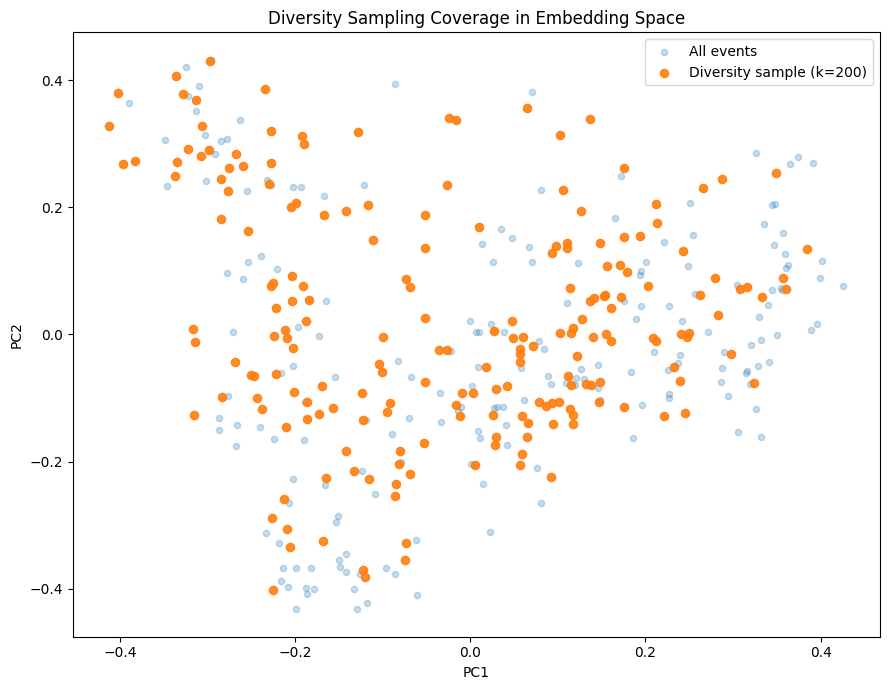

In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

mask = np.zeros(X.shape[0], dtype=bool)
mask[diverse_idx] = True

plt.figure(figsize=(9, 7))

plt.scatter(
    X_2d[~mask, 0],
    X_2d[~mask, 1],
    alpha=0.25,
    s=20,
    label="All events")

plt.scatter(
    X_2d[mask, 0],
    X_2d[mask, 1],
    alpha=0.9,
    s=35,
    label="Diversity sample (k=200)")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Diversity Sampling Coverage in Embedding Space")
plt.legend()
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


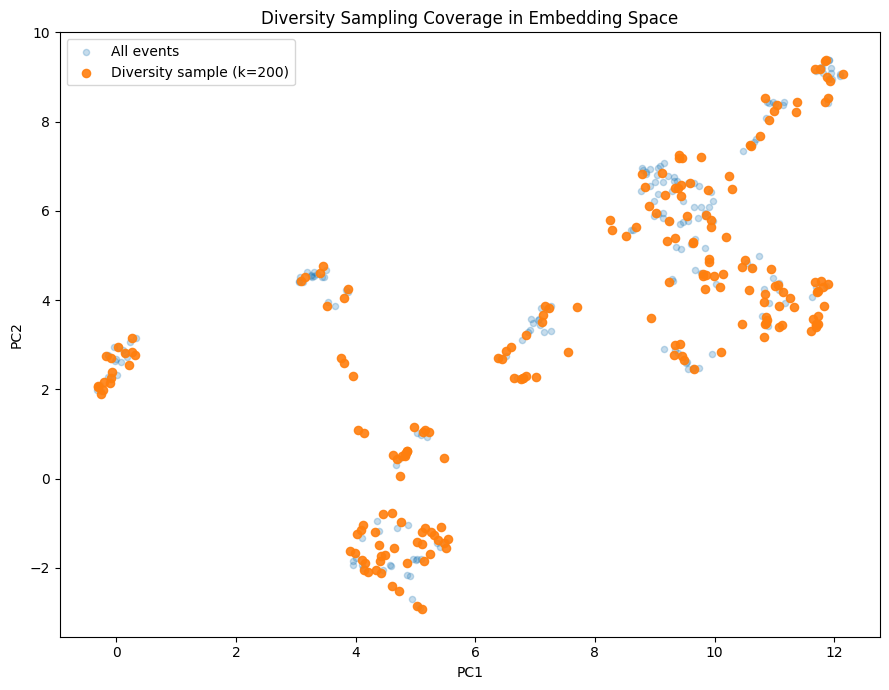

In [120]:
import umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42)

X_2d = reducer.fit_transform(X)

mask = np.zeros(X.shape[0], dtype=bool)
mask[diverse_idx] = True

plt.figure(figsize=(9, 7))

plt.scatter(
    X_2d[~mask, 0],
    X_2d[~mask, 1],
    alpha=0.25,
    s=20,
    label="All events")

plt.scatter(
    X_2d[mask, 0],
    X_2d[mask, 1],
    alpha=0.9,
    s=35,
    label="Diversity sample (k=200)")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Diversity Sampling Coverage in Embedding Space")
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
df_diverse.head()

,row_index,classification,mechanism,actors,tactics,targets,outcome,confidence,rationale,keywords
369,369,Peasant-led armed tax rebellion against fiscal...,[Imposition of direct land taxation replacing ...,"[Tigrean peasants, Tigrean nobles and local le...",[Armed uprising and coalition-building across ...,[Land tax law and direct tax collection system...,[Rebellion militarily defeated with British ai...,0.86,The uprising (Weyane) was directly catalyzed b...,"[Weyane, Tigre, land tax, direct taxation, tax..."
389,389,Tax protest strike by business owners over une...,[Collective action against discriminatory taxa...,"[Paris restauranteurs, Fast food establishment...","[Strike, Street demonstration, Public grievanc...","[French tax authorities, Municipal or national...","[Thirty demonstrators arrested, Public attenti...",0.78,The event is a coordinated strike and protest ...,"[Paris, restauranteurs, tax disparity, fast fo..."
197,197,Parliamentary resistance to proposed regular t...,[Negotiated fiscal contract between crown and ...,"[Robert Cecil, earl of Salisbury, King James I...",[Proposal of the Great Contract (annual grant ...,"[Crown finances and royal revenue system, Prop...",[Great Contract rejected by both crown and Par...,0.74,The episode centers on a proposed tax-and-priv...,"[Great Contract, James I, Robert Cecil, Parlia..."
144,144,Anti-tribute secession and tax refusal ending ...,"[Collective refusal to pay tribute, Withholdin...",[Ivan III and the Grand Principality of Muscov...,"[Nonpayment of tribute and taxes, Coordination...","[Golden Horde fiscal demands (tribute, taxes, ...",[Golden Horde punitive expedition withdrew wit...,0.86,The event centers on coordinated refusal to pa...,"[tribute refusal, tax nonpayment, Golden Horde..."
386,386,Representation-based tax protest seeking exemp...,"[Taxation without representation grievance, Le...",[Coalition for D.C. Representation in Congress...,[Slogan and messaging campaign ('No Taxation W...,[U.S. Congress (voting representation and dele...,[Partial political reforms (home rule; nonvoti...,0.78,The episode centers on protesting federal taxa...,"[District of Columbia, taxation without repres..."


##### LLM-Based Taxonomy Creation and Assignment

After constructing a representative diversity sample, the next two LLM calls operationalize the taxonomy itself: **(1) taxonomy creation** and **(2) taxonomy assignment**.

In the first call, the LLM is provided with the diversity sample and instructed to synthesize a **set of 10 taxonomies** that capture the major, recurring modes of tax-related conflict and resistance present across the corpus. Because the sample spans the full semantic space of events, the resulting taxonomies are not anchored to a specific era, geography, or protest form, but instead reflect structurally distinct patterns (e.g., popular rebellion, institutional contestation, organized political movements). The model is asked to produce concise labels and definitions, ensuring interpretability and consistency.

In the second call, these 10 taxonomies are held fixed and applied back to the **entire dataset**. Each event is classified into the single most appropriate taxonomy, along with a **taxonomy confidence score** reflecting the model’s certainty that the assignment aligns with the taxonomy’s definition.

In [ ]:
SYSTEM = """You are a PhD-level methodologist.
Design a thesis-grade taxonomy for classifying tax-related contentious events.
Return STRICT JSON only (one line)."""

compact = []
for _, r in df_diverse.iterrows():
    compact.append({
        "row_index": int(r["row_index"]) if "row_index" in r else int(r.name),
        "classification": r.get("classification"),
        "mechanism": (r.get("mechanism") or [])[:6],
        "tactics": (r.get("tactics") or [])[:6],
        "targets": (r.get("targets") or [])[:6],
        "outcome": (r.get("outcome") or [])[:6],
        "keywords": (r.get("keywords") or [])[:10],
    })


PROMPT = f"""
You are given machine-generated codings for historical tax-related events.
Your task: propose EXACTLY 10 broad, mutually exclusive, collectively exhaustive classes.

Output JSON with:
- classes: list of 10 objects, each with:
  - id (1..10)
  - name (3-6 words)
  - definition (2-4 sentences)
  - include_rules (3-6 strings)
  - exclude_rules (2-4 strings)
  - typical_signals (list of phrases/keywords)
- assignment_policy:
  - tie_breakers (ordered list)
  - how_to_handle_non_rebellion_policy_items (string)
  - how_to_handle_multi_episode_entries (string)

Here is the data (diversity-maximized sample):
{json.dumps(compact, ensure_ascii=False)}
""".strip()

resp = client.chat.completions.create(
    model=MODEL,
    temperature=0.2,
    messages=[{"role": "system", "content": SYSTEM},
              {"role": "user", "content": PROMPT}]
)

taxonomy = json.loads(resp.choices[0].message.content)
taxonomy["classes"][:2]

In [ ]:
ASSIGN_MODEL = MODEL          
BATCH_SIZE = 30               
OUT_ASSIGN = "taxonomy_assignments.jsonl"
MAX_RETRIES = 6
RETRY_BASE_SLEEP = 1.5

df_ok = df_lab[df_lab.get("error").isna() if "error" in df_lab.columns else [True]*len(df_lab)].copy()

def make_assignment_record(r: pd.Series) -> dict:
    return {
        "row_index": int(r["row_index"]),
        "classification": r.get("classification"),
        "mechanism": (r.get("mechanism") or [])[:6],
        "tactics": (r.get("tactics") or [])[:6],
        "targets": (r.get("targets") or [])[:6],
        "outcome": (r.get("outcome") or [])[:6],
        "keywords": (r.get("keywords") or [])[:10],
    }

records = [make_assignment_record(r) for _, r in df_ok.iterrows()]
print("Rows to assign:", len(records))

Rows to assign: 391


In [ ]:
ASSIGN_SYSTEM = """You are a PhD-level methodologist.
Assign each event to EXACTLY ONE of the 10 taxonomy classes provided.
Return STRICT JSON only (one line)."""

def already_done(path: str) -> set[int]:
    if not os.path.exists(path):
        return set()
    done = set()
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            done.add(int(obj["row_index"]))
    return done

done = already_done(OUT_ASSIGN)

def make_assign_prompt(taxonomy: dict, batch: list[dict]) -> str:
    # include class id/name/definition/include/exclude/signals + tie breakers
    tax_for_prompt = {
        "classes": taxonomy["classes"],
        "assignment_policy": taxonomy.get("assignment_policy", {})
    }
    return f"""
You are given:
1) A taxonomy with exactly 10 classes.
2) A batch of event codings.

Task:
For EACH event, choose exactly one class id (1..10) that best fits.
Use definitions + include/exclude rules + tie-breakers.

Return JSON:
{{
  "assignments": [
    {{
      "row_index": <int>,
      "taxonomy_id": <int 1..10>,
      "taxonomy_name": <string exactly matching the chosen class name>,
      "confidence": <float 0..1>,
      "short_reason": <string, <= 20 words>
    }},
    ...
  ]
}}

Taxonomy:
{json.dumps(tax_for_prompt, ensure_ascii=False)}

Events:
{json.dumps(batch, ensure_ascii=False)}
""".strip()

In [ ]:
with open(OUT_ASSIGN, "a", encoding="utf-8") as f:
    for start in range(0, len(records), BATCH_SIZE):
        batch = records[start:start + BATCH_SIZE]

        # skip rows already done
        batch = [b for b in batch if b["row_index"] not in done]
        if not batch:
            continue

        prompt = make_assign_prompt(taxonomy, batch)

        for attempt in range(MAX_RETRIES):
            try:
                resp = client.chat.completions.create(
                    model=ASSIGN_MODEL,
                    temperature=0.0,  # assignment should be deterministic
                    messages=[
                        {"role": "system", "content": ASSIGN_SYSTEM},
                        {"role": "user", "content": prompt},
                    ],
                )
                payload = json.loads(resp.choices[0].message.content)

                for a in payload["assignments"]:
                    f.write(json.dumps(a, ensure_ascii=False) + "\n")
                    done.add(int(a["row_index"]))

                f.flush()
                time.sleep(0.3)  
                break

            except Exception as e:
                if attempt == MAX_RETRIES - 1:
                    for b in batch:
                        f.write(json.dumps({"row_index": b["row_index"], "error": str(e)}, ensure_ascii=False) + "\n")
                        done.add(int(b["row_index"]))
                    f.flush()
                else:
                    time.sleep(RETRY_BASE_SLEEP * (2 ** attempt))

In [ ]:
## READ jsonl ASSIGNMENTS TO DF

assign_rows = []
with open(OUT_ASSIGN, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        # ignore error lines, keep successful assignments
        if "taxonomy_id" in obj:
            assign_rows.append(obj)

df_assign = pd.DataFrame(assign_rows)

df_mapped = df_lab.merge(df_assign, on="row_index", how="left")

id_to_name = {c["id"]: c["name"] for c in taxonomy["classes"]}
df_mapped["taxonomy_name"] = df_mapped["taxonomy_id"].map(id_to_name).fillna(df_mapped["taxonomy_name"])

print("Assigned:", df_mapped["taxonomy_id"].notna().sum(), "of", len(df_mapped))

df_mapped = df_mapped.rename(columns={"confidence_x":"event_confidence", "confidence_y":"taxonomy_confidence"})

df_mapped[["row_index", "taxonomy_id", "taxonomy_name", "taxonomy_confidence"]].head(10)

In [61]:
df_mapped

,row_index,classification,mechanism,actors,tactics,targets,outcome,event_confidence,rationale,keywords,taxonomy_id,taxonomy_name,taxonomy_confidence,short_reason
0,0,Popular uprising against oppressive taxation l...,"[Tax revolt, Anti-bureaucratic backlash, Regim...","[Lagash citizens (farmers, herders, fishermen,...","[Collective uprising, Expulsion/overthrow of r...","[Ur-Nanshe dynasty, Tax collectors and inspect...","[Dynasty overthrown and replaced by Urukagina,...",0.74,The description explicitly links oppressive ta...,"[Lagash, Urukagina, Ur-Nanshe dynasty, tax col...",1,Armed anti-tax popular rebellion,0.78,Popular uprising overthrowing dynasty; tax col...
1,1,Urban tax resistance leading to negotiated fis...,"[Collective refusal or resistance to taxes, tr...",[Native-born citizens of privileged cities (As...,"[Withholding taxes and tribute, Refusal of cor...","[Monarchical fiscal claims (toll, tribute, cus...",[Formalized exemptions from taxes and corvée f...,0.74,The description links city resistance to payin...,"[kiddinu, kiddinutu, free city, tax exemption,...",1,Armed anti-tax popular rebellion,0.60,Urban rebellion/civil conflict with withholdin...
2,2,Anti-tribute revolt within an imperial allianc...,"[Resistance to burdensome tribute assessments,...",[Delian League allied city-states (Ionian and ...,[Collective uprising and secession attempts by...,"[Athenian tribute system and assessments, Athe...",[Outbreak and intensification of the Peloponne...,0.78,The description centers on allied city-states ...,"[Delian League, Athens, tribute, allied revolt...",10,Inter-polity tribute and toll conflict,0.86,Allied city-states vs Athens over tribute; esc...
3,3,Anti-tax uprising leading to deposition of a r...,"[War finance taxation backlash, Fiscal repress...","[Egyptian taxpayers and populace, Egyptian pol...","[Uprising and mass unrest, Political revolt cu...","[Pharaoh Tachos, Royal fiscal administration a...","[Deposition of Tachos as pharaoh, Termination ...",0.78,"The description explicitly links heavy, repres...","[Tachos, Egypt, repressive taxation, war finan...",1,Armed anti-tax popular rebellion,0.70,Mass uprising over war taxes culminating in de...
4,4,Anti-imperial tax revolt against Persian rule ...,[Resistance to heavy taxation and fiscal extra...,"[Pharaoh Khabbash and Egyptian rebels, Persian...","[Armed rebellion, Political mobilization aroun...","[Persian tax collectors and administrators, Pe...",[Revolt occurred or was attempted but is poorl...,0.62,The description links the uprising to Persian ...,"[Khabbash, Artaxerxes III, Persian rule in Egy...",1,Armed anti-tax popular rebellion,0.74,Armed anti-imperial revolt against Persian fis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,386,Representation-based tax protest seeking exemp...,"[Taxation without representation grievance, Le...",[Coalition for D.C. Representation in Congress...,[Slogan and messaging campaign ('No Taxation W...,[U.S. Congress (voting representation and dele...,[Partial political reforms (home rule; nonvoti...,0.78,The episode centers on protesting federal taxa...,"[District of Columbia, taxation without repres...",5,Organized anti-tax movement politics,0.64,Ongoing organized advocacy linking taxes to re...
387,387,Tax grievance–driven separatist political move...,[Perceived fiscal extraction and unequal redis...,[Alberta Independence Party members and suppor...,[Formation of separatist political organizatio...,"[Federal taxation and fiscal transfer system, ...",[Growth of organized separatist advocacy in Al...,0.74,The description centers on organized western C...,"[Alberta separatism, tax grievances, fiscal tr...",5,Organized anti-tax movement politics,0.90,Separatist organizations mobilize around fisca...
388,388,Anti-income tax protest escalating into a tax ...,[Mass mobilization against proposed tax policy...,"[Anti-income tax protesters, Talk radio hosts ...","[Capitol rally and chanting, Crowding and blo

In [ ]:
summary = (
    df_mapped
    .groupby(["taxonomy_id", "taxonomy_name"])
    .agg(
        n_events=("taxonomy_id", "size"),
        avg_confidence=("taxonomy_confidence", "mean"),
        sd_confidence=("taxonomy_confidence", "std"),
        low_confidence_share=("taxonomy_confidence", lambda x: (x < 0.6).mean()))
    .reset_index()
    .sort_values("n_events", ascending=False))

summary.sort_values('taxonomy_id')

,taxonomy_id,taxonomy_name,n_events,avg_confidence,sd_confidence,low_confidence_share
0,1,Armed anti-tax popular rebellion,158,0.836835,0.094735,0.000000
1,2,Nonviolent mass tax resistance,22,0.695909,0.121328,0.227273
2,3,Public protest and tax riot,87,0.781264,0.121165,0.103448
3,4,Illicit evasion and contraband networks,7,0.837143,0.174615,0.142857
4,5,Organized anti-tax movement politics,16,0.771250,0.144816,0.062500
5,6,Institutional fiscal contestation,59,0.809831,0.119315,0.050847
6,7,Petitionary and grievance redress,16,0.796250,0.121758,0.062500
7,8,Exit-based tax resistance,9,0.861111,0.103856,0.000000
8,9,State-led fiscal policy change,5,0.800000,0.180555,0.200000
9,10,Inter-polity tribute and toll conflict,12,0.785000,0.148661,0.166667


In [71]:
final_df2 = final_df.reset_index(drop=True).copy()
final_df2["row_index"] = final_df2.index  

final_df_mapped = final_df2.merge(
    df_mapped[["row_index", "taxonomy_id", "taxonomy_name", "taxonomy_confidence"]],
    on="row_index",
    how="left",
    validate="one_to_one")

final_df_mapped = final_df_mapped.drop(columns=["row_index"])

final_df_mapped.head()

,Rebellion,Time Period,Location,Description,Bibliography,See References,taxonomy_id,taxonomy_name,taxonomy_confidence
0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,tax reduction and related reforms effected by ...,"Samuel Noah Kramer, From the Tablets of Sumer....",None,1,Armed anti-tax popular rebellion,0.78
1,Kiddinutu,2000 BC,Assyria,"legal “status of being under the kiddinu,” ass...","A.Leo Oppenheim, Ancient Mesopotamia: Portrait...",None,1,Armed anti-tax popular rebellion,0.60
2,Delian League Revolt,431 BC,Greece,uprising of cities allied with Athens in the D...,"Andreas Michael Andreades, A History of Greek ...",None,10,Inter-polity tribute and toll conflict,0.86
3,Rebellion Against Tachos,c. 361 or 360 BC,Egypt,uprising instigated by repressive taxation imp...,"B.G.Trigger et al., Ancient Egypt: A Social Hi...",None,1,Armed anti-tax popular rebellion,0.70
4,Khabbash Revolt,c. 338 BC,Egypt,"apparent uprising, led by the pharaoh Khabbash...","B.G.Trigger et al., Ancient Egypt: A Social Hi...",None,1,Armed anti-tax popular rebellion,0.74


### LLM GEOCODING

This section uses an LLM to infer approximate spatiotemporal information for each tax-related event based on its textual description. Because the source material frequently references historical regions, polities, or culturally defined places (rather than modern, geocodable locations), direct geocoding is not feasible at scale. The goal here is therefore not to recover exact coordinates, but to produce a *plausible spatial centroid*, a *temporal interval*, and *explicit confidence estimates* that capture uncertainty inherent in historical sources. These outputs are later used to weight, rather than hard-classify, events in spatial and temporal analyses.

In [3]:
final_df_mapped = pd.read_csv("~/Desktop/tax-revolt-project/final_df_mapped.csv", index_col=0)

In [4]:
OUT_JSONL = "geo_time_llm_cache.jsonl"         
MODEL = "gpt-5.2-chat-latest"
TEMPERATURE = 1

SLEEP_BETWEEN_CALLS = 0.3
MAX_RETRIES = 3

df = final_df_mapped.copy()

def load_done_indices(path: str) -> set:
    """Return set of row_index already written to cache."""
    if not os.path.exists(path):
        return set()
    done = set()
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                if "row_index" in obj and "error" not in obj:
                    done.add(int(obj["row_index"]))
            except json.JSONDecodeError:
                continue
    return done

done = load_done_indices(OUT_JSONL)
print("Already cached:", len(done), "rows")
print("Total rows:", len(df))

Already cached: 0 rows
Total rows: 391


##### LLM-based spatiotemporal inference

In the following API call, each event is passed to the LLM with its rebellion name, time period, location string, and a short excerpt of the description. The model is instructed to (1) convert the textual time reference into a start and end year using astronomical year numbering, (2) infer a reasonable geographic centroid for the described location without inventing precise borders, and (3) return confidence scores for both the temporal and spatial estimates. Confidence scores are requested explicitly so that downstream analyses can account for ambiguity probabilistically, rather than treating all inferred locations and dates as equally certain.

In [5]:
SYSTEM = """You are a historical methodologist and historical geographer.
Estimate a spatiotemporal footprint for each historical event.

Rules:
- Convert time to start_year and end_year using ASTRONOMICAL year numbering:
  * 1 BC = year 0, 2 BC = -1, 431 BC = -430
- If time is uncertain (e.g., c., circa, early/mid/late, decade), widen the interval.
- DO NOT invent precise borders or polygons.
- Output a plausible centroid (lat, lon) and an uncertainty radius_km.
- Use conservative uncertainty when ambiguous.
- Confidence is epistemic: how likely your estimate matches scholarly consensus.

Return STRICT JSON only. No extra text.
"""

def make_prompt(row) -> str:
    rebellion = str(row.get("Rebellion", "")).strip()
    time_period = str(row.get("Time Period", "")).strip()
    location = str(row.get("Location", "")).strip()
    description = str(row.get("Description", "")).strip()

    return f"""
Estimate the spatiotemporal footprint of this event.

Event:
- rebellion: {rebellion}
- time_period: {time_period}
- location: {location}
- description: {description[:800]}

Return JSON with:
- time:
  - start_year: integer
  - end_year: integer
  - confidence: number 0..1
  - note: string (<= 120 chars)
- space:
  - latitude: number
  - longitude: number
  - radius_km: integer
  - confidence: number 0..1
  - place_label: string (short)
  - reasoning: string (<= 180 chars)
- overall_confidence: number 0..1
""".strip()

In [6]:
def call_llm_for_row(row_index: int, row: pd.Series) -> dict:
    prompt = make_prompt(row)

    for attempt in range(1, MAX_RETRIES + 1):
        try:
            resp = client.chat.completions.create(
                model=MODEL,
                temperature=TEMPERATURE,
                response_format={"type": "json_object"},
                messages=[
                    {"role": "system", "content": SYSTEM},
                    {"role": "user", "content": prompt}
                ],
            )

            content = resp.choices[0].message.content.strip()
            data = json.loads(content)

            data["row_index"] = int(row_index)

            # minimal validation
            assert "time" in data and "space" in data
            assert "start_year" in data["time"] and "end_year" in data["time"]
            assert "latitude" in data["space"] and "longitude" in data["space"]

            # optional: normalize inverted intervals
            if data["time"]["end_year"] < data["time"]["start_year"]:
                data["time"]["start_year"], data["time"]["end_year"] = (
                    data["time"]["end_year"], data["time"]["start_year"]
                )

            return data

        except Exception as e:
            if attempt == MAX_RETRIES:
                return {
                    "row_index": int(row_index),
                    "error": str(e),
                    "raw_output": content if "content" in locals() else None
                }
            time.sleep(0.5 * attempt)

In [7]:
remaining = [(i, df.iloc[i]) for i in range(len(df)) if i not in done]
print("Remaining to resolve:", len(remaining))

with open(OUT_JSONL, "a", encoding="utf-8") as f:
    for row_index, row in remaining:
        result = call_llm_for_row(row_index, row)
        f.write(json.dumps(result, ensure_ascii=False) + "\n")
        f.flush()

        # pacing to avoid rate spikes
        time.sleep(SLEEP_BETWEEN_CALLS)

print("Done. Cache written to:", OUT_JSONL)

Remaining to resolve: 391
Done. Cache written to: geo_time_llm_cache.jsonl


In [101]:
def load_cache(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            rows.append(obj)
    return pd.DataFrame(rows)

cache_df = load_cache(OUT_JSONL)

# Keep successes only for mapping
ok = cache_df[cache_df.get("error").isna() if "error" in cache_df.columns else [True]*len(cache_df)].copy()

# Flatten nested dicts
ok["start_year"] = ok["time"].apply(lambda x: x.get("start_year") if isinstance(x, dict) else np.nan)
ok["end_year"]   = ok["time"].apply(lambda x: x.get("end_year")   if isinstance(x, dict) else np.nan)
ok["time_conf"]  = ok["time"].apply(lambda x: x.get("confidence") if isinstance(x, dict) else np.nan)

ok["lat"]        = ok["space"].apply(lambda x: x.get("latitude")  if isinstance(x, dict) else np.nan)
ok["lon"]        = ok["space"].apply(lambda x: x.get("longitude") if isinstance(x, dict) else np.nan)
ok["radius_km"]  = ok["space"].apply(lambda x: x.get("radius_km") if isinstance(x, dict) else np.nan)
ok["space_conf"] = ok["space"].apply(lambda x: x.get("confidence") if isinstance(x, dict) else np.nan)
ok["place_label"] = ok["space"].apply(lambda x: x.get("place_label") if isinstance(x, dict) else np.nan)

ok["overall_conf"] = ok.get("overall_confidence", np.nan)
ok["row_index"] = ok["row_index"].astype(int)

geo_df = df.reset_index().rename(columns={"index":"row_index"}).merge(
    ok[["row_index","start_year","end_year","time_conf","lat","lon","radius_km","space_conf","place_label","overall_conf"]],
    on="row_index",
    how="left")

geo_df = geo_df.rename(columns = {'overall_conf':'place_confidence'})

geo_df.head()

,row_index,Rebellion,Time Period,Location,Description,Bibliography,See References,taxonomy_id,taxonomy_name,taxonomy_confidence,start_year,end_year,time_conf,lat,lon,radius_km,space_conf,place_label,place_confidence
0,0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,tax reduction and related reforms effected by ...,"Samuel Noah Kramer, From the Tablets of Sumer....",NaN,1,Armed anti-tax popular rebellion,0.78,-2360,-2330,0.65,31.41,46.17,40,0.8,"Lagash (Tello), Sumer",0.65
1,1,Kiddinutu,2000 BC,Assyria,"legal “status of being under the kiddinu,” ass...","A.Leo Oppenheim, Ancient Mesopotamia: Portrait...",NaN,1,Armed anti-tax popular rebellion,0.60,-1999,-499,0.55,35.45,43.25,550,0.6,Assur–Babylonia core,0.57
2,2,Delian League Revolt,431 BC,Greece,uprising of cities allied with Athens in the D...,"Andreas Michael Andreades, A History of Greek ...",NaN,10,Inter-polity tribute and toll conflict,0.86,-431,-426,0.66,38.00,24.00,600,0.6,Aegean world (Delian League),0.63
3,3,Rebellion Against Tachos,c. 361 or 360 BC,Egypt,uprising instigated by repressive taxation imp...,"B.G.Trigger et al., Ancient Egypt: A Social Hi...",NaN,1,Armed anti-tax popular rebellion,0.70,-361,-359,0.55,29.90,31.20,600,0.6,Egypt (Memphis-centered),0.57
4,4,Khabbash Revolt,c. 338 BC,Egypt,"apparent uprising, led by the pharaoh Khabbash...","B.G.Trigger et al., Ancient Egypt: A Social Hi...",NaN,1,Armed anti-tax popular rebellion,0.74,-340,-336,0.55,26.50,30.50,500,0.5,Egypt (Nile Valley),0.52


##### Expanding events across time bins with uncertainty-aware weighting

This function transforms each historical tax event into one or more **time-binned spatial observations**, enabling events with uncertain or multi-year dates to be analyzed consistently over time. Using the LLM-inferred `start_year` and `end_year`, each event is assigned to all fixed-width `year_bin`s (e.g., 50-year bins) that it spans.

Each event’s total contribution is weighted **only by temporal and spatial confidence** (`time_conf` and `space_conf`), reflecting uncertainty about *when* and *where* the event occurred. This weighted contribution is then **evenly distributed across all occupied time bins**, ensuring that events with longer or more uncertain durations are proportionally diffused rather than concentrated in a single period.

The resulting dataframe contains one row per `(event × year_bin)` combination and preserves key metadata—including the original event label, time period, book-reported and LLM-inferred locations, taxonomy assignment, and confidence scores—alongside a spatial centroid. This structure supports uncertainty-aware temporal aggregation and interactive spatial visualization without conflating classification uncertainty with event magnitude.

In [122]:
def explode_years(df_in: pd.DataFrame, bin_width: int = 50) -> pd.DataFrame:
    rows = []

    for _, r in df_in.iterrows():
        if (
            pd.isna(r.get("start_year"))
            or pd.isna(r.get("end_year"))
            or pd.isna(r.get("lat"))
            or pd.isna(r.get("lon"))
        ):
            continue

        y0 = int(r["start_year"])
        y1 = int(r["end_year"])
        if y1 < y0:
            y0, y1 = y1, y0

        # --- bin years (inclusive across bins) ---
        bins = list(
            range(
                (y0 // bin_width) * bin_width,
                (y1 // bin_width) * bin_width + bin_width,
                bin_width
            )
        )
        if not bins:
            continue

        # --- event weight (same as your logic) ---
        base = 1.0
        if not pd.isna(r.get("time_conf")):
            base *= float(r["time_conf"])
        if not pd.isna(r.get("space_conf")):
            base *= float(r["space_conf"])

        w = base / len(bins)

        for b in bins:
            rows.append({
                "row_index": int(r["row_index"]),
                "rebellion": str(r.get("Rebellion", "")),
                "time_period": str(r.get("Time Period", "")),   
                "book_location": str(r.get("Location", "")),
                "llm_location": str(r.get("place_label", "")),

                "taxonomy_name": r.get("taxonomy_name", None),
                "taxonomy_confidence": (
                    float(r["taxonomy_confidence"]) if not pd.isna(r.get("taxonomy_confidence")) else np.nan),

                "place_confidence": (
                    float(r["place_confidence"]) if not pd.isna(r.get("place_confidence")) else np.nan),

                "year_bin": int(b),
                "lat": float(r["lat"]),
                "lon": float(r["lon"]),
                "weight": float(w)})

    return pd.DataFrame(rows)

BIN_WIDTH = 50
events_binned = explode_years(geo_df, bin_width=BIN_WIDTH)
events_binned.head()

,row_index,rebellion,time_period,book_location,llm_location,taxonomy_name,taxonomy_confidence,place_confidence,year_bin,lat,lon,weight
0,0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,"Lagash (Tello), Sumer",Armed anti-tax popular rebellion,0.78,0.65,-2400,31.41,46.17,0.260000
1,0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,"Lagash (Tello), Sumer",Armed anti-tax popular rebellion,0.78,0.65,-2350,31.41,46.17,0.260000
2,1,Kiddinutu,2000 BC,Assyria,Assur–Babylonia core,Armed anti-tax popular rebellion,0.60,0.57,-2000,35.45,43.25,0.010645
3,1,Kiddinutu,2000 BC,Assyria,Assur–Babylonia core,Armed anti-tax popular rebellion,0.60,0.57,-1950,35.45,43.25,0.010645
4,1,Kiddinutu,2000 BC,Assyria,Assur–Babylonia core,Armed anti-tax popular rebellion,0.60,0.57,-1900,35.45,43.25,0.010645


### VISUALIZATIONS

In [123]:
final_df_mapped = pd.read_csv("~/Desktop/tax-revolt-project/final_df_mapped.csv", index_col=0)

In [124]:
final_df_mapped.head()

,Rebellion,Time Period,Location,Description,Bibliography,See References,taxonomy_id,taxonomy_name,taxonomy_confidence
0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer,tax reduction and related reforms effected by ...,"Samuel Noah Kramer, From the Tablets of Sumer....",NaN,1,Armed anti-tax popular rebellion,0.78
1,Kiddinutu,2000 BC,Assyria,"legal “status of being under the kiddinu,” ass...","A.Leo Oppenheim, Ancient Mesopotamia: Portrait...",NaN,1,Armed anti-tax popular rebellion,0.60
2,Delian League Revolt,431 BC,Greece,uprising of cities allied with Athens in the D...,"Andreas Michael Andreades, A History of Greek ...",NaN,10,Inter-polity tribute and toll conflict,0.86
3,Rebellion Against Tachos,c. 361 or 360 BC,Egypt,uprising instigated by repressive taxation imp...,"B.G.Trigger et al., Ancient Egypt: A Social Hi...",NaN,1,Armed anti-tax popular rebellion,0.70
4,Khabbash Revolt,c. 338 BC,Egypt,"apparent uprising, led by the pharaoh Khabbash...","B.G.Trigger et al., Ancient Egypt: A Social Hi...",NaN,1,Armed anti-tax popular rebellion,0.74


##### Parsing historical time expressions into weighted calendar years

This code translates **human-written historical date expressions** (e.g., “c. 2350 BC”, “Early 900s”, “361 or 360 BC”) into a standardized set of **calendar years with associated weights**, allowing events with vague or uncertain dating to be analyzed quantitatively over time.

**Crucially, this parser operates on the book-provided `Time Period` field**—the original qualitative dating recorded in the source texts. It does *not* use the later LLM-derived `start_year` / `end_year` estimates, which are handled separately in the geocoding and spatiotemporal footprint step.

###### Astronomical year numbering
All dates are converted to **astronomical year numbering**, which avoids the gap between 1 BC and AD 1:
- 1 BC → year 0  
- 2 BC → year −1  
- 431 BC → year −430  

This convention allows BC and AD dates to be treated as a single continuous number line, which is essential for computation, binning, and visualization.

###### Handling uncertainty and imprecision
Historical dates are frequently approximate rather than exact. This code explicitly encodes that uncertainty:
- **Circa dates (`c.` or `circa`)** are expanded into a ±5-year window around the stated year.
- **Century phrases** such as *Early 900s*, *Mid 900s*, and *Late 900s* are mapped to fixed year ranges within the century (e.g., Early = 900–933).
- **Decades** (e.g., *1840s*) are expanded to all ten years in the decade.
- **Alternatives** (e.g., *361 or 360 BC*) are treated as equally plausible anchor years.
- **Ranges** (e.g., *1901–1905* or *240–237 BC*) include every year between the endpoints, inclusive.

In all cases, uncertainty is represented by *spreading* an event’s temporal presence rather than assigning a single definitive year.

###### Uniform weighting logic
When an event expands into multiple years, its total weight is **distributed uniformly** across those years:
- Each expanded year receives an equal share.
- A decade assigns each year a weight of 0.1.
- A circa window of ±5 years assigns each year a weight of 1/11.

The sum of weights for any single event always equals 1, ensuring that temporal uncertainty widens an event’s footprint without inflating its overall importance.

###### Building the time-expanded dataset
This logic is applied to the full dataset by expanding each event into one or more `(year, weight)` rows derived from the **book-coded time period**. These rows retain taxonomy assignments and can be aggregated by year to produce uncertainty-aware temporal summaries, such as stream graphs and long-run trend visualizations.

Overall, this approach converts qualitative historical dating conventions into a transparent, mathematically consistent representation of time while remaining faithful to historical uncertainty.

In [16]:
CIRCA_UNC = 5  # +/- years around "c. YEAR" / "circa YEAR"

EARLY_CENTURY_SPAN = (0, 33)   # 900–933
MID_CENTURY_SPAN   = (34, 66)  # 934–966
LATE_CENTURY_SPAN  = (67, 99)  # 967–999


def bc_to_astronomical(year_bc: int) -> int:
    """
    Convert BC year to astronomical year numbering:
      1 BC -> 0, 2 BC -> -1, 431 BC -> -430
    """
    return -(year_bc - 1)


def normalize_dashes(s: str) -> str:
    """Normalize various dash characters to en-dash '–'."""
    return str(s).replace("—", "–").replace("-", "–")


def strip_circa(s: str) -> tuple[str, bool]:
    """
    Remove 'c.' / 'circa' and return (cleaned_string, is_circa_flag).
    """
    s = str(s)
    is_circa = bool(re.search(r"\bc\.\b|\bcirca\b", s, flags=re.I))
    s_clean = re.sub(r"\bc\.\s*|\bcirca\s*", "", s, flags=re.I).strip()
    return s_clean, is_circa


def parse_year_token(token: str) -> int:
    """
    Parse tokens like:
      - 'AD 6', 'AD6'
      - '431 BC'
      - '711'
    Return astronomical year int.
    """
    t = token.strip()

    m = re.match(r"^AD\s*(\d{1,4})$", t, flags=re.I)
    if m:
        return int(m.group(1))

    m = re.match(r"^(\d{1,4})\s*BC$", t, flags=re.I)
    if m:
        return bc_to_astronomical(int(m.group(1)))

    m = re.match(r"^(\d{1,4})$", t)
    if m:
        return int(m.group(1))

    raise ValueError(f"Unrecognized year token: {token}")


def uniform_weights(years: list[int]) -> list[tuple[int, float]]:
    """Return [(year, weight)] with weights summing to 1."""
    if not years:
        return []
    w = 1.0 / len(years)
    return [(y, w) for y in years]


def expand_circa(years: list[int], unc: int = CIRCA_UNC) -> list[tuple[int, float]]:
    """
    Expand a set of anchor years into +/- unc windows and distribute weight uniformly.
    """
    if not years:
        return []
    per_anchor = 1.0 / len(years)
    out: list[tuple[int, float]] = []
    for y in years:
        window = list(range(y - unc, y + unc + 1))
        ww = per_anchor / len(window)
        out.extend([(yy, ww) for yy in window])
    return out


def years_from_time_period(s: str) -> list[tuple[int, float]]:
    """
    Returns a list of (year, weight) pairs that sum to 1 for this event.

    Supported examples:
      - "c. 544"
      - "Early 900s"
      - "1840s"
      - "361 or 360 BC"
      - "1901–1905"
      - "240–237 BC"
      - "AD 820–823"
    """
    if s is None or str(s).strip() == "" or str(s).strip().lower() == "nan":
        return []

    s_norm = normalize_dashes(str(s).strip())
    s_clean, is_circa = strip_circa(s_norm)

    m = re.match(r"^(Early|Mid|Late)\s+(\d{3})s$", s_clean, flags=re.I)
    if m:
        part = m.group(1).lower()
        base = int(m.group(2))
        if part == "early":
            a, b = EARLY_CENTURY_SPAN
        elif part == "mid":
            a, b = MID_CENTURY_SPAN
        else:
            a, b = LATE_CENTURY_SPAN

        years = list(range(base + a, base + b + 1))
        return uniform_weights(years)

    m = re.match(r"^(\d{3,4})0s$", s_clean)
    if m:
        start = int(m.group(1)) * 10
        years = list(range(start, start + 10))
        return uniform_weights(years)

    if re.search(r"\bor\b", s_clean, flags=re.I):
        parts = [p.strip() for p in re.split(r"\bor\b", s_clean, flags=re.I)]
        anchors = [parse_year_token(p) for p in parts]
        return expand_circa(anchors) if is_circa else uniform_weights(anchors)

    if "–" in s_clean:
        a, b = [t.strip() for t in s_clean.split("–", 1)]
        y0 = parse_year_token(a)
        y1 = parse_year_token(b)

        if y1 < y0:
            y0, y1 = y1, y0

        if is_circa:
            y0 -= CIRCA_UNC
            y1 += CIRCA_UNC

        years = list(range(y0, y1 + 1))
        return uniform_weights(years)

    y = parse_year_token(s_clean)
    if is_circa:
        years = list(range(y - CIRCA_UNC, y + CIRCA_UNC + 1))
        return uniform_weights(years)

    return [(y, 1.0)]


def build_stream_df(final_df_mapped: pd.DataFrame) -> pd.DataFrame:
    """
    Expand each event into one-or-many year rows with weights summing to 1 per event.
    """
    rows = []
    for idx, r in final_df_mapped.iterrows():
        pairs = years_from_time_period(r["Time Period"])
        for year, w in pairs:
            rows.append({
                "row_index": idx,
                "year": year,
                "taxonomy_id": r["taxonomy_id"],
                "taxonomy_name": r["taxonomy_name"],
                "weight": w,
            })
    return pd.DataFrame(rows)

stream_df = build_stream_df(final_df_mapped)
yearly = stream_df.groupby(["year", "taxonomy_name"], as_index=False)["weight"].sum()

In [17]:
BIN_WIDTH = 50 

yearly_binned = yearly.copy()
yearly_binned["year_bin"] = (yearly_binned["year"] // BIN_WIDTH) * BIN_WIDTH

yearly_binned = (
    yearly_binned
    .groupby(["year_bin", "taxonomy_name"], as_index=False)["weight"]
    .sum())

yearly_all = (
    yearly_binned
    .groupby("year_bin", as_index=False)["weight"]
    .sum())

min_bin = int(yearly_binned["year_bin"].min())
max_bin = int(yearly_binned["year_bin"].max())

all_bins = pd.DataFrame({"year_bin": np.arange(min_bin, max_bin + BIN_WIDTH, BIN_WIDTH)})
all_tax = pd.DataFrame({"taxonomy_name": sorted(yearly_binned["taxonomy_name"].dropna().unique())})

yearly_all_full = (
    all_bins.merge(yearly_all, on="year_bin", how="left")
            .fillna({"weight": 0}))

grid = all_bins.merge(all_tax, how="cross")

yearly_binned_full = (grid.merge(yearly_binned, on=["year_bin", "taxonomy_name"], how="left").fillna({"weight": 0}))

##### Temporal distribution of tax-related events

The first visualization shows the **aggregate temporal distribution** of tax-related events across the entire corpus. Each event contributes a fractional weight to every fixed-width `year_bin` it spans (here, 50-year bins), based on its inferred duration and associated uncertainty. Years are assigned to bins using integer floor division (e.g., `year_bin = (year // 50) * 50`), which means that **all years from 2000 through 2049 are grouped into the 2000 bin**. As a result, events dated to 2002 appear in the 2000 bin, just as events dated to 1951 appear in the 1950 bin. This produces a consistent, non-overlapping temporal grid across the entire historical range.

The resulting area chart represents the **weighted number of events per time bin**, allowing long-running or imprecisely dated events to contribute smoothly across time rather than appearing as sharp spikes.

The second visualization disaggregates this temporal signal by **taxonomy category**. Here, the stacked area chart shows how different forms of tax contention rise and fall across the same fixed bin structure, with each colored band representing a taxonomy’s weighted contribution within each bin. Because all weights are normalized at the event level before binning, changes in the stacked areas reflect shifts in the *composition* of tax-related activity over time rather than artifacts of bin alignment or isolated calendar years.

In [22]:
import altair as alt

chart_all = alt.Chart(yearly_all_full).mark_area(opacity=0.7).encode(
    x=alt.X("year_bin:Q", axis=alt.Axis(title="Year (binned)", tickSize=0)),
    y=alt.Y("weight:Q", axis=alt.Axis(title="Weighted number of events"), stack=None),
    tooltip=[alt.Tooltip("year_bin:Q"), alt.Tooltip("weight:Q", format=".2f")]
).properties(
    width=900, height=450,
    title=f"Tax-related events over time ({BIN_WIDTH}-year bins)")

chart_all

alt.Chart(...)

In [23]:
chart = alt.Chart(yearly_binned_full).mark_area().encode(
    x=alt.X(
        "year_bin:Q",
        axis=alt.Axis(title=f"Year ({BIN_WIDTH}-year bins)", labelAngle=0)),
    y=alt.Y(
        "weight:Q",
        stack="zero",
        axis=alt.Axis(title="Weighted number of events")),
    color=alt.Color(
        "taxonomy_name:N",
        legend=alt.Legend(title="Taxonomy")),
    tooltip=[
        alt.Tooltip("year_bin:Q", title="Year bin"),
        alt.Tooltip("taxonomy_name:N"),
        alt.Tooltip("weight:Q", format=".2f")]
).properties(
    width=1000,
    height=450,
    title=f"Taxonomy counts over time ({BIN_WIDTH}-year bins)")

chart

alt.Chart(...)

##### Interactive spatial distribution of tax-related events

The final visualization maps tax-related events onto a global projection, combining **temporal filtering with spatial exploration**. Events are represented as circles positioned at LLM-derived geographic centroids. A time slider allows users to move through fixed-width year bins, displaying only those events whose inferred durations intersect the selected period.

Circle **size and color both encode event weight**, which reflects temporal and spatial confidence and is normalized across bins. Larger, darker points indicate events with higher certainty or shorter temporal spans, while smaller, lighter points represent more uncertain or long-duration events. Rich tooltips expose the full metadata for each event—including original book location, LLM-resolved place name, confidence scores, and taxonomy—allowing users to inspect overlapping events that would otherwise be difficult to distinguish. The map is fully interactive, supporting zooming and panning to resolve dense regional clusters and closely co-located events.

In [137]:
from vega_datasets import data

world = alt.topo_feature(data.world_110m.url, "countries")

BIN_WIDTH = 50

weight_min = 0.0
weight_max = float(events_binned["weight"].max()) if len(events_binned) else 1.0

min_year = int(events_binned["year_bin"].min())
max_year = int(events_binned["year_bin"].max())

year_param = alt.param(
    name="year_bin",
    value=min_year,
    bind=alt.binding_range(
        min=min_year,
        max=max_year,
        step=BIN_WIDTH,
        name="Year "
    )
)

base = alt.Chart(world).mark_geoshape(
    fill="lightgray",
    stroke="white",
    strokeWidth=0.5
).properties(
    width=900,
    height=450
).project("equalEarth")

pts = alt.Chart(events_binned).mark_circle(
    opacity=0.8,
    stroke="black",
    strokeWidth=0.2
).encode(
    longitude=alt.Longitude("lon:Q"),
    latitude=alt.Latitude("lat:Q"),

    size=alt.Size(
        "weight:Q",
        title="Weight",
        scale=alt.Scale(domain=[weight_min, weight_max], range=[20, 800])
    ),

    color=alt.Color(
        "weight:Q",
        title="Weight",
        scale=alt.Scale(domain=[weight_min, weight_max], scheme="reds")
    ),

    tooltip=[
        alt.Tooltip("rebellion:N", title="Event"),
        alt.Tooltip("time_period:N", title="Time period"),
        alt.Tooltip("year_bin:Q", title="Year bin"),
        alt.Tooltip("weight:Q", format=".4f", title="Event weight"),

        alt.Tooltip("book_location:N", title="Location (Book)"),
        alt.Tooltip("llm_location:N", title="Location (LLM)"),

        alt.Tooltip("place_confidence:Q", title="Location confidence", format=".2f"),

        alt.Tooltip("taxonomy_name:N", title="Taxonomy"),
        alt.Tooltip("taxonomy_confidence:Q", title="Taxonomy confidence", format=".2f"),
    ],
).add_params(
    year_param
).transform_filter(
    "datum.year_bin == year_bin"
)

chart = (base + pts).properties(title=f"Tax-related events ({BIN_WIDTH}-year bins)").interactive()

chart

alt.LayerChart(...)

### TEXT-EMBED ML CLASSIFICATION

##### Unsupervised text embedding and clustering of event descriptions

In this step, I embedded each event’s **raw textual description** using a transformer-based text embedding model and applied unsupervised machine learning to explore latent structure in the corpus. The embeddings were L2-normalized and projected into lower-dimensional space using UMAP, after which HDBSCAN was used to identify dense clusters without pre-specifying the number of groups. Cluster membership was inspected by listing the rebellion name, time period, and location for each cluster.

While this pipeline successfully grouped events with similar language, the results show that clustering was **dominated by geographic signals**: clusters largely correspond to regions (e.g., China, Iberia, Latin America) rather than to mechanisms, actors, or forms of tax contention. This occurs because historical descriptions frequently encode place names, polities, and region-specific institutions, which strongly influence semantic similarity in embedding space. As a result, the clusters primarily reflect **where events occurred**, not analytically meaningful categories of tax resistance. For this reason, the unsupervised clustering results are treated as exploratory and are not used directly as substantive classifications.

In [ ]:
import os
import time
from openai import OpenAI
from dotenv import load_dotenv

## LOAD IN API KEY
load_dotenv("tax_revolt_project.env")
OPENAI_API_KEY =  os.getenv("OPENAI_API_KEY") 

client = OpenAI()  # uses OPENAI_API_KEY from env

In [ ]:
EMBED_MODEL = "text-embedding-3-small"

BATCH_SIZE = 128          # reduce if you hit request size limits
MAX_RETRIES = 8           
RETRY_BASE_SLEEP = 1.5    # seconds
NORMALIZE = True          # cosine-sim friendly

df = final_df.copy()

In [ ]:
## CREATE TEXT EMBEDDINGS 

df["embed_text_desc"] = df["Description"].str.strip()

def _l2_normalize(mat: np.ndarray) -> np.ndarray:
    denom = np.linalg.norm(mat, axis=1, keepdims=True)
    denom[denom == 0] = 1.0
    return mat / denom

def embed_texts(texts: list[str], model: str, batch_size: int = 128) -> np.ndarray:
    """
    Returns: (n_texts, dim) float32 array
    """
    all_vecs = []
    n = len(texts)

    for start in range(0, n, batch_size):
        batch = texts[start:start + batch_size]

        # retry loop (handles transient 429/5xx)
        for attempt in range(MAX_RETRIES):
            try:
                resp = client.embeddings.create(
                    model=model,
                    input=batch,
                    encoding_format="float")
                
                vecs = [item.embedding for item in resp.data]
                all_vecs.append(np.array(vecs, dtype=np.float32))
                break
            except Exception as e:
                if attempt == MAX_RETRIES - 1:
                    raise
                sleep_s = RETRY_BASE_SLEEP * (2 ** attempt)
                time.sleep(sleep_s)

    mat = np.vstack(all_vecs)
    return mat

X_desc = embed_texts(df["embed_text_desc"].tolist(), model=EMBED_MODEL, batch_size=BATCH_SIZE)

if NORMALIZE:
    X_desc = _l2_normalize(X_desc)

print("X_desc shape:", X_desc.shape)

np.save("embeddings_desc.npy", X_desc)

df[["Rebellion","Time Period","Location"]].to_parquet("embedding_rows.parquet", index=False)

X_desc shape: (391, 1536)
X_desc_meta shape: (391, 1536)


In [ ]:
## ALIGNMENT SANITY CHECK

X_desc = np.load("embeddings_desc.npy")
X_desc_meta = np.load("embeddings_desc_meta.npy")
rows = pd.read_parquet("embedding_rows.parquet")

assert X_desc.shape[0] == len(rows)
assert X_desc_meta.shape[0] == len(rows)

print("Rows:", len(rows))
print("Example row 0:", rows.iloc[0].to_dict())

Rows: 391
Example row 0: {'Rebellion': 'Urukagina’s Reform', 'Time Period': 'c. 2350 BC', 'Location': 'Babylonia/Sumer'}


In [ ]:
## SIMILARITY SANITY CHECK 

def cosine(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

print("Self-sim desc:", cosine(X_desc[0], X_desc[0]))
print("Cross item desc:", cosine(X_desc[0], X_desc[1]))

Self-sim desc: 1.0000001192092896
Cross item desc: 0.5372462868690491


In [ ]:
import umap

X = X_desc

umap_2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.05,
    metric="cosine",
    random_state=7
).fit_transform(X)

umap_10d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    n_components=10,
    metric="cosine",
    random_state=7
).fit_transform(X)

print(umap_2d.shape, umap_10d.shape)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(391, 2) (391, 10)


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=3,
    metric="euclidean")

labels = clusterer.fit_predict(umap_10d)
print("Clusters found:", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise points:", (labels == -1).sum())

Clusters found: 10
Noise points: 3


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = df["Description"].astype(str).tolist()

vec = TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2))
X_tfidf = vec.fit_transform(texts)
terms = np.array(vec.get_feature_names_out())

out = []
for c in sorted(set(labels)):
    if c == -1:
        continue
    idx = np.where(labels == c)[0]
    tfidf_mean = X_tfidf[idx].mean(axis=0).A1
    top = terms[np.argsort(-tfidf_mean)[:12]].tolist()
    out.append({"cluster": c, "n": len(idx), "top_terms": ", ".join(top)})

pd.DataFrame(out).sort_values(["n"], ascending=False).head(20)

,cluster,n,top_terms
4,4,164,"tax, king, taxes, rebels, louis, government, p..."
7,7,59,"roman, emperor, empire, rome, tax, leo, byzant..."
1,1,35,"tax, peasants, government, china, ch, salt, co..."
8,8,27,"peasants, fief, tax, rising, rice, rebels, dem..."
3,3,24,"indians, tax, rebellion, alcabala, government,..."
9,9,22,"ottoman, sultan, muslims, tax, christians, syr..."
6,6,18,"peasants, cossacks, alexis, tsar, moscow, otto..."
5,5,17,"peasants, robot, joseph, labor, service, labor..."
2,2,13,"cortes, catalonia, philip, castile, spain, por..."
0,0,9,"palermo, sicily, viceroy, crispi, naples, sici..."


In [ ]:
# ## ATTACH LABELS
df = df.copy()
df["cluster"] = labels

# ## SUMMARY
summary = (
    df["cluster"]
    .value_counts(dropna=False)
    .rename_axis("cluster")
    .reset_index(name="n")
    .sort_values("cluster")
)

n_clusters = (summary["cluster"] != -1).sum()
n_noise = int((df["cluster"] == -1).sum())

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)
display(summary)

Clusters found: 10
Noise points: 3


,cluster,n
10,-1,3
9,0,9
2,1,35
8,2,13
4,3,24
0,4,164
7,5,17
6,6,18
1,7,59
3,8,27


In [ ]:
# ## CLUSTER TOP TERMS (TF-IDF)
cluster_terms = []
for c in sorted(df["cluster"].unique()):
    if c == -1:
        continue
    idx = np.where(labels == c)[0]
    tfidf_mean = X_tfidf[idx].mean(axis=0).A1
    top = terms[np.argsort(-tfidf_mean)[:15]].tolist()
    cluster_terms.append({
        "cluster": int(c),
        "n": int(len(idx)),
        "top_terms": ", ".join(top)
    })

cluster_terms_df = pd.DataFrame(cluster_terms).sort_values("n", ascending=False)
display(cluster_terms_df)

,cluster,n,top_terms
4,4,164,"tax, king, taxes, rebels, louis, government, p..."
7,7,59,"roman, emperor, empire, rome, tax, leo, byzant..."
1,1,35,"tax, peasants, government, china, ch, salt, co..."
8,8,27,"peasants, fief, tax, rising, rice, rebels, dem..."
3,3,24,"indians, tax, rebellion, alcabala, government,..."
9,9,22,"ottoman, sultan, muslims, tax, christians, syr..."
6,6,18,"peasants, cossacks, alexis, tsar, moscow, otto..."
5,5,17,"peasants, robot, joseph, labor, service, labor..."
2,2,13,"cortes, catalonia, philip, castile, spain, por..."
0,0,9,"palermo, sicily, viceroy, crispi, naples, sici..."


In [ ]:
# ## PRINT MEMBERS PER CLUSTER
SHOW_ROWS_PER_CLUSTER = None   # set to e.g. 30 to truncate long clusters

for c in sorted(df["cluster"].unique()):
    if c == -1:
        continue

    block = (
        df.loc[df["cluster"] == c, ["Rebellion", "Time Period", "Location"]]
          .reset_index(drop=True)
    )

    print("\n" + "="*110)
    print(f"CLUSTER {c} | n={len(block)}")
    print("="*110)

    if SHOW_ROWS_PER_CLUSTER is not None:
        display(block.head(SHOW_ROWS_PER_CLUSTER))
    else:
        display(block)


CLUSTER 0 | n=9


,Rebellion,Time Period,Location
0,Sicilian Vespers Revolt,1282,Sicily
1,Palermo Revolt,1647,"Sicily, Spanish Kingdom"
2,Naples Revolt,1647–1648,"Italy, Spanish Kingdom"
3,Palermo Revolt,1773,"Sicily, Italy"
4,Carriage Tax Revolt,1782,Sicily
5,Nobles’ Tax Rebellion,1810,Sicily
6,Revolution of 1848,1848,Sicily
7,Anti-tax Riots,1891,Italy
8,Sicily Rebellion,1894,Italy



CLUSTER 1 | n=35


,Rebellion,Time Period,Location
0,Li-t’ien,191 BC,China
1,Tax Remission,141 BC,China
2,Discourses on Salt and Iron,81 BC,China
3,Wang Mang’s Reforms,AD 9,China
4,Land Tax Riots,AD 30,China
5,Commanderies Tax Revolt,AD 116,China
6,Buddhist Clergy Growth,c. 460,China
7,Falsification of Records,c. 582,China
8,Ling-nan Rising,687,China
9,Suppressing Buddhist Tax Evasion,711,China



CLUSTER 2 | n=13


,Rebellion,Time Period,Location
0,Remensas’ Protests,1388,Spain
1,Barcelona Riots,1391,Spain
2,Remenca Serfs’ Rising,1462,Spain
3,Great Revolt in Castile,1520–1521,Spain
4,Cortes Tax Refusals,1543–1545,Spain
5,Revolt of the Netherlands,1567,Spanish Habsburg Empire
6,Castile Tax Resistance,1573–1577,Spain
7,Millones protests,1589,Spain
8,Catalonia Rebellion,1626,Spanish Kingdom
9,Vizcaya Revolt,1631–1632,Spain



CLUSTER 3 | n=24


,Rebellion,Time Period,Location
0,Cuetaxtla Protest,1400,Mexico
1,and 1641 Tunja Sales Tax Revolts,1592,Colombia
2,Indigo Tax Evasion,1659,Guatemala
3,Repartimiento Protest,1683,Guatemala
4,Mosquito Coast Rebellion,1712,Central America
5,Piche Settlement,1729,Guatemala
6,Bourbon Fiscal Reform Resistance,1763,Guatemala
7,Rebellion of the Barrios,1765,Ecuador
8,Guanajuato Riot,1767,Mexico
9,Cochabamba Customhouse Riot,1774,Bolivia



CLUSTER 4 | n=164


,Rebellion,Time Period,Location
0,Kiddinutu,2000 BC,Assyria
1,Injuriosus’s Protest,c. 544,Kingdom of the Franks
2,Limoges Riot,578,Kingdom of the Franks
3,Bishop Gregory’s Tax Resistance,589,Kingdom of the Franks
4,Danegeld Resistance,991,Britain
...,...,...,...
159,D.C. Vote,2000,United States
160,Separatist Movement,2001,Canada
161,Tennessee Income Tax Protest,2001,United States
162,Restauranteurs’ Strike,2002,France



CLUSTER 5 | n=17


,Rebellion,Time Period,Location
0,Limonta Peasants’ Protest,882–905,Italy
1,Bundschuh,1502,Germany/Switzerland
2,“Poor Conrad” Rebellion (Arme Konrad),1514,Germany
3,"Peasants’ Revolt (Peasants’ War, Bauernkrieg)",1524–1525,Germany/Austria
4,Reichenstein Rising,1567,Austria
5,Rappenkrieg,1591–1594,Switzerland
6,Peasants’ Revolt,1594,Austria
7,Peasant Risings,1595–1597,Austria
8,Peasants’ Revolt,1597,"Hungary, Austrian Monarchy"
9,Peasants’ Uprising,1626,Austria



CLUSTER 6 | n=18


,Rebellion,Time Period,Location
0,Thomas the Slav’s Revolt,820–823,Byzantium
1,Muscovy Tribute Resistance,1480,Russia
2,Croat Rising,1573,"Hungary, Austrian Monarchy"
3,Michael’s Revolt,1594,"Romania, Ottoman Empire"
4,Time of Troubles,1598–1613,Russia
5,Bolotnikov Rebellion,1606–1607,Russia
6,Moscow Uprising,1648,Russia
7,Kolomenskoe Protest,1662,Russia
8,Rakoczi’s Insurrection,1703,"Hungary, Austrian Empire"
9,Lower Don Rebellion,1707–1708,Russia



CLUSTER 7 | n=59


,Rebellion,Time Period,Location
0,Delian League Revolt,431 BC,Greece
1,Rebellion Against Tachos,c. 361 or 360 BC,Egypt
2,Khabbash Revolt,c. 338 BC,Egypt
3,Mercenary War,240–237 BC,"Carthage, North Africa"
4,Rhodes/Byzantium War,220 BC,Near East
5,Tax Farming Controversy,c. 220 BC,"Palestine, Egyptian Kingdom"
6,Sitologi Protests,c. 200 BC,Egypt
7,Black Market Complaint,113 BC,Egypt
8,Hyrcanus Opposition,67 BC,Judaea
9,Opposition to Triumvirs’ Taxes,44 BC,Roman Empire



CLUSTER 8 | n=27


,Rebellion,Time Period,Location
0,Urukagina’s Reform,c. 2350 BC,Babylonia/Sumer
1,Fukuyama Rising,1717,Japan
2,Sanchu Ikki,1726–1727,Japan
3,Iwaki Daira Rising,1739,Japan
4,Aizu Rising,1749,Japan
5,Fukuyama Rising,1752,Japan
6,Ueda Horeki Rising,1761–1763,Japan
7,Tenma Sodo,1764–1765,Japan
8,Fukuyama Rising,1770,Japan
9,Koyasan Revolt,1776,Japan



CLUSTER 9 | n=22


,Rebellion,Time Period,Location
0,Bedouin Revolt,Early 900s,Iraq
1,Basra Riot,917,Iraq
2,Anatolian Rebellions,1285,"Asia Minor, Byzantium"
3,Peasants’ Revolt,1332–1334,India
4,Tax Farming Complaints,1563–1564,Ottoman Empire
5,Census Opposition,1572,"Cyprus, Ottoman Empire"
6,Celali Revolts,1596–1610,Ottoman Empire
7,“The Great Flight”,1603–1608,Ottoman Empire
8,Customs Protest,1648,Ottoman Empire
9,Homs Revolt,1826,Syria


,cluster,n
0,4,164
1,7,59
2,1,35
3,8,27
4,3,24
5,9,22
6,6,18
7,5,17
8,2,13
9,0,9


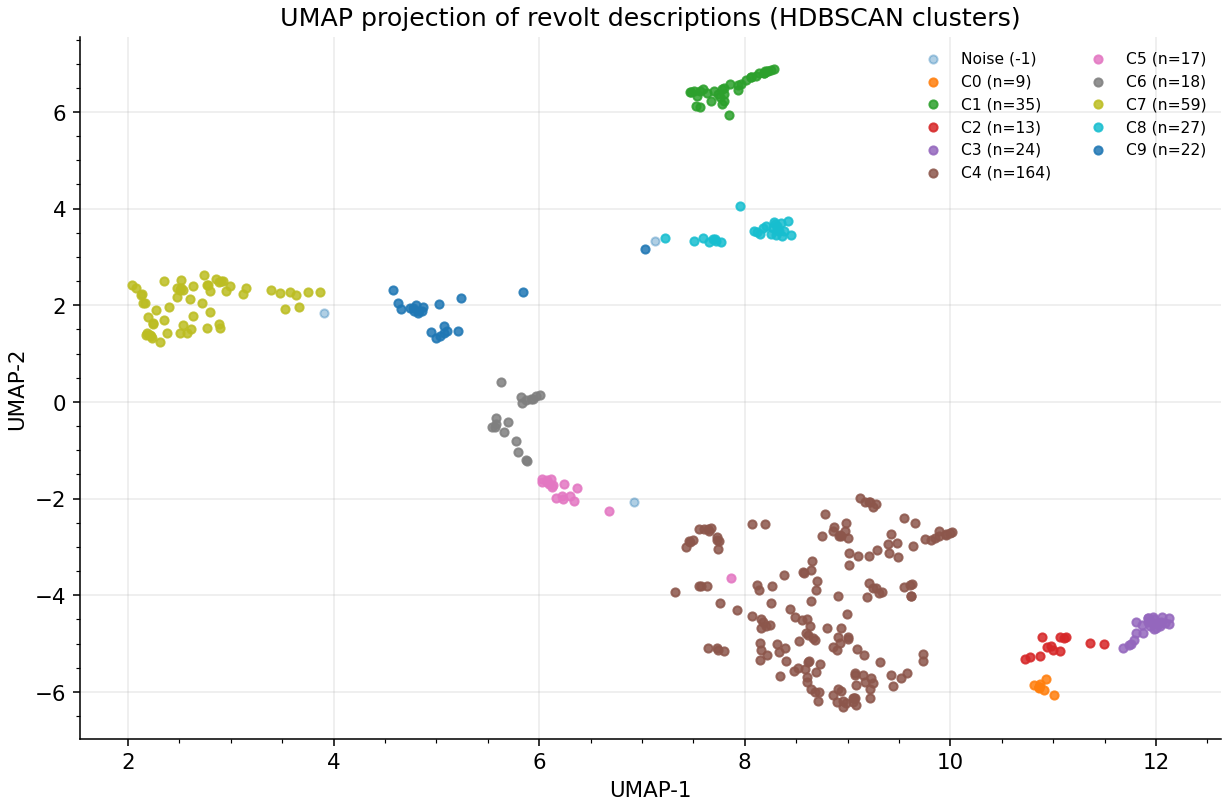

In [ ]:
## UMAP SCATTER
import matplotlib.pyplot as plt

## ATTACH UMAP + CLUSTERS INTO ONE TABLE 
df = df.copy()
df["cluster"] = labels
df["umap_x"] = umap_2d[:, 0]
df["umap_y"] = umap_2d[:, 1]

# handy quick summary
cluster_sizes = (
    df["cluster"].value_counts()
      .rename_axis("cluster")
      .reset_index(name="n")
      .sort_values("n", ascending=False)
)

display(cluster_sizes)

FIG_W, FIG_H = 9, 6
POINT_SIZE = 18
ALPHA = 0.85

plt.figure(figsize=(FIG_W, FIG_H))

# noise first (so clusters draw on top)
noise = df["cluster"] == -1
plt.scatter(df.loc[noise, "umap_x"], df.loc[noise, "umap_y"],
            s=POINT_SIZE, alpha=0.35, label="Noise (-1)")

for c in sorted(df["cluster"].unique()):
    if c == -1:
        continue
    m = df["cluster"] == c
    plt.scatter(df.loc[m, "umap_x"], df.loc[m, "umap_y"],
                s=POINT_SIZE, alpha=ALPHA, label=f"C{c} (n={m.sum()})")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP projection of revolt descriptions (HDBSCAN clusters)")
plt.legend(loc="best", fontsize=8, frameon=False, ncol=2)
plt.tight_layout()
plt.show()

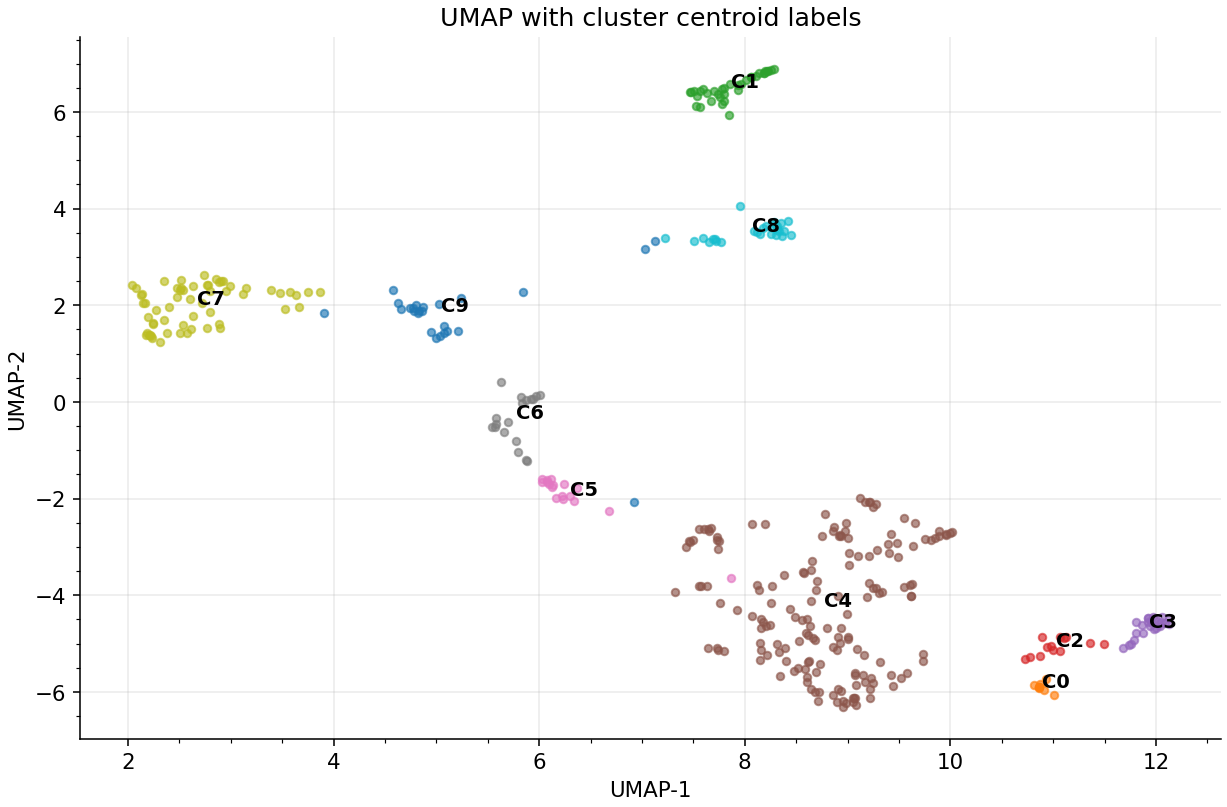

In [ ]:
## LABEL CLUSTER CENTERS ON THE UMAP PLOT
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

for c in sorted(df["cluster"].unique()):
    m = df["cluster"] == c
    plt.scatter(df.loc[m, "umap_x"], df.loc[m, "umap_y"], s=15, alpha=0.65)

    if c == -1:
        continue

    cx = df.loc[m, "umap_x"].mean()
    cy = df.loc[m, "umap_y"].mean()
    plt.text(cx, cy, f"C{c}", fontsize=10, weight="bold")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP with cluster centroid labels")
plt.tight_layout()
plt.show()

In [ ]:
## QUALITY METRICS
from sklearn.metrics import silhouette_score

# exclude noise
mask = df["cluster"] != -1
X_used = X[mask.values]
y_used = df.loc[mask, "cluster"].values

# silhouette needs a distance metric; with normalized embeddings, cosine is meaningful
sil = silhouette_score(X_used, y_used, metric="cosine")
print("Silhouette (cosine, excluding noise):", round(float(sil), 4))

# within-cluster cohesion: mean cosine similarity to cluster centroid
cohesion = []
for c in sorted(np.unique(y_used)):
    idx = np.where(y_used == c)[0]
    Xc = X_used[idx]
    centroid = Xc.mean(axis=0, keepdims=True)
    centroid /= np.linalg.norm(centroid, axis=1, keepdims=True)
    sims = (Xc @ centroid.T).ravel()
    cohesion.append({"cluster": int(c), "n": int(len(idx)), "mean_cosine_to_centroid": float(sims.mean())})

cohesion_df = pd.DataFrame(cohesion).sort_values("mean_cosine_to_centroid", ascending=False)
display(cohesion_df)

Silhouette (cosine, excluding noise): 0.0972


,cluster,n,mean_cosine_to_centroid
0,0,9,0.827299
5,5,17,0.785218
2,2,13,0.761283
8,8,27,0.758322
1,1,35,0.757773
3,3,24,0.751623
6,6,18,0.734283
9,9,22,0.724194
7,7,59,0.696967
4,4,164,0.663734
